In [1]:
# Necessary libraries and data load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
# Data load
# machine-learning stack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
#!pip install imbalanced-learn
from sklearn.metrics import confusion_matrix
#!unzip data/train.zip -d data/train
import pandas as pd
#to deal with unbalanced target dist: pip install imbalanced-learn
from imblearn.pipeline import make_pipeline as imb_pipe
from imblearn.over_sampling import RandomOverSampler
df = pd.read_csv('merged_invoice_client.csv', delimiter=',')
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

- aggregation by client_id
- relavant info by client
- how many invoices by client
- freq of invoices: mean by month?
- stratify split
- class imbalance in target
- class_weight=balanced log_reg

# Data
Variable definitions

Client:

    Client_id: Unique id for client
    District: District where the client is
    Client_catg: Category client belongs to
    Region: Area where the client is
    Creation_date: Date client joined
    Target: fraud:1 , not fraud: 0

Invoice data

    Client_id: Unique id for the client
    Invoice_date: Date of the invoice
    Tarif_type: The variable definition in Zindi is misleading. Column has nothing to Nominal (unordered)
    Discrete, Encodes billing logic, not quantity
    Counter_number:
    Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
    Counter_code:
    Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
    Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
    Consommation_level_1: Consumption_level_1
    Consommation_level_2: Consumption_level_2
    Consommation_level_3: Consumption_level_3
    Consommation_level_4: Consumption_level_4
    Old_index: Old index
    New_index: New index
    Months_number: Month number
    Counter_type: Type of counter


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   disrict                    135493 non-null  int64  
 1   client_id                  135493 non-null  int64  
 2   client_catg                135493 non-null  int64  
 3   region                     135493 non-null  int64  
 4   creation_date              135493 non-null  object 
 5   target                     135493 non-null  float64
 6   consommation_level_1_mean  135493 non-null  float64
 7   consommation_level_2_mean  135493 non-null  float64
 8   consommation_level_3_mean  135493 non-null  float64
 9   consommation_level_4_mean  135493 non-null  float64
 10  invoice_date_min           135493 non-null  object 
 11  invoice_date_max           135493 non-null  object 
 12  invoice_date_count         135493 non-null  int64  
 13  total_consumption_mean     13

In [3]:
df.head()

,disrict,client_id,client_catg,region,creation_date,target,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,...,coef_nunique,coef_changed,code_nunique,code_mode,code_last,remark_nunique,remark_mode,remark_last,counter_type,counter_type2
0,60,0,11,101,1994-12-31,0.0,352.400000,10.571429,0.000000,0.000000,...,1,0,2,203,207,3,6,9,ELEC,1
1,69,1,11,107,2002-05-29,0.0,557.540541,0.000000,0.000000,0.000000,...,1,0,1,203,203,3,6,9,ELEC,1
2,62,10,11,301,1986-03-13,0.0,798.611111,37.888889,0.000000,0.000000,...,1,0,2,203,207,3,6,9,ELEC,1
3,69,100,11,105,1996-07-11,0.0,1.200000,0.000000,0.000000,0.000000,...,1,0,1,413,413,2,6,9,ELEC,1
4,62,1000,11,303,2014-10-14,0.0,663.714286,104.857143,117.357143,36.714286,...,1,0,1,207,207,2,9,8,ELEC,1


In [4]:
# Categorical columns. How many different values do they take?
# Do they change by client?
df.nunique()

disrict                           4
client_id                    135493
client_catg                       3
region                           25
creation_date                  8088
target                            2
consommation_level_1_mean     94937
consommation_level_2_mean     51696
consommation_level_3_mean     26573
consommation_level_4_mean     16247
invoice_date_min               6548
invoice_date_max               6401
invoice_date_count              260
total_consumption_mean       102629
no_consumption_flag               2
n_invoices                      260
first_invoice                  6548
last_invoice                   6401
meter_delta_mean             100157
meter_delta_median             6959
meter_delta_std              124863
delta_per_month_mean         111572
delta_per_month_std          125780
n_nonpositive_delta             118
n_zero_delta                    119
first_old_index               34052
last_new_index                47394
index_range                 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   disrict                    135493 non-null  int64  
 1   client_id                  135493 non-null  int64  
 2   client_catg                135493 non-null  int64  
 3   region                     135493 non-null  int64  
 4   creation_date              135493 non-null  object 
 5   target                     135493 non-null  float64
 6   consommation_level_1_mean  135493 non-null  float64
 7   consommation_level_2_mean  135493 non-null  float64
 8   consommation_level_3_mean  135493 non-null  float64
 9   consommation_level_4_mean  135493 non-null  float64
 10  invoice_date_min           135493 non-null  object 
 11  invoice_date_max           135493 non-null  object 
 12  invoice_date_count         135493 non-null  int64  
 13  total_consumption_mean     13

In [6]:
#invoice.head(36).sort_values(by=[ 'client_id', 'invoice_date'])
#it seems that counter_code&coefficient vary for a customer, but counter_statue does not. But lets check below.

## Train-Test Split

In [7]:
X=df.drop(['target'], axis=1)
y=df[['target']]
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (135493, 39)
Shape of y: (135493, 1)


In [8]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (101619, 39)
Shape of X_test: (33874, 39)
Shape of y_train: (101619, 1)
Shape of y_test: (33874, 1)


In [9]:
#For EDA we put together train sets
df_train=pd.concat([X_train, y_train], axis=1)

In [10]:
df_train.counter_type2.value_counts(normalize=True)

counter_type2
1    0.850874
2    0.149126
Name: proportion, dtype: float64

In [11]:
# target imbalance in training and test data
print(f'Train data target distribution: {y_train.value_counts(normalize=True)}')
print(f'Test data target distribution: {y_test.value_counts(normalize=True)}')

Train data target distribution: target
0.0       0.944164
1.0       0.055836
Name: proportion, dtype: float64
Test data target distribution: target
0.0       0.944146
1.0       0.055854
Name: proportion, dtype: float64


In [12]:
# target imbalance in training and test data
print(f'Train data target distribution: {y_train.value_counts()}')
print(f'Test data target distribution: {y_test.value_counts()}')

Train data target distribution: target
0.0       95945
1.0        5674
Name: count, dtype: int64
Test data target distribution: target
0.0       31982
1.0        1892
Name: count, dtype: int64


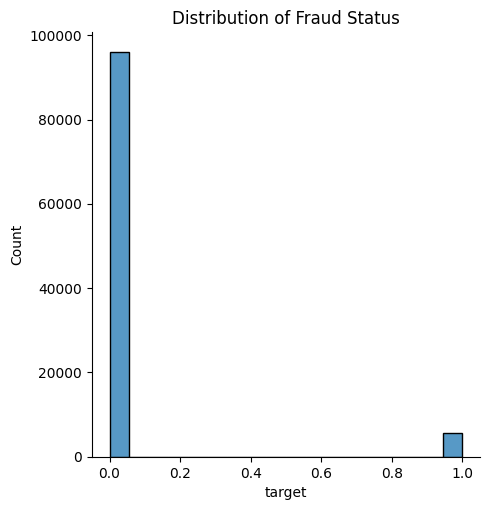

In [13]:
sns.displot(data=df_train, x='target')
plt.title('Distribution of Fraud Status')
plt.show()

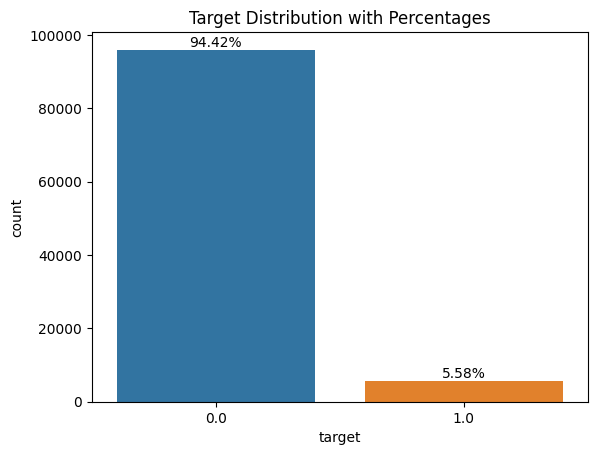

In [14]:
ax = sns.countplot(data=df_train, x='target')

total = len(df_train)

for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    ax.annotate(
        f'{pct:.2f}%',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.title('Target Distribution with Percentages')
plt.savefig("target_dist.png")
plt.show()


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   disrict                    135493 non-null  int64  
 1   client_id                  135493 non-null  int64  
 2   client_catg                135493 non-null  int64  
 3   region                     135493 non-null  int64  
 4   creation_date              135493 non-null  object 
 5   target                     135493 non-null  float64
 6   consommation_level_1_mean  135493 non-null  float64
 7   consommation_level_2_mean  135493 non-null  float64
 8   consommation_level_3_mean  135493 non-null  float64
 9   consommation_level_4_mean  135493 non-null  float64
 10  invoice_date_min           135493 non-null  object 
 11  invoice_date_max           135493 non-null  object 
 12  invoice_date_count         135493 non-null  int64  
 13  total_consumption_mean     13

In [16]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
disrict,101619.0,63.512365,3.353314,60.000,62.000000,62.000000,69.000000,6.900000e+01
client_id,101619.0,67657.222842,39132.620227,0.000,33791.500000,67587.000000,101506.000000,1.354910e+05
client_catg,101619.0,11.499287,4.365286,11.000,11.000000,11.000000,11.000000,5.100000e+01
region,101619.0,206.249796,104.188729,101.000,103.000000,107.000000,307.000000,3.990000e+02
consommation_level_1_mean,101619.0,433.450571,817.084477,0.000,215.864469,356.000000,541.366071,9.992000e+04
consommation_level_2_mean,101619.0,115.966880,777.923899,0.000,0.000000,5.054054,63.364745,1.156830e+05
consommation_level_3_mean,101619.0,27.322524,121.238194,0.000,0.000000,0.000000,3.966667,1.400000e+04
consommation_level_4_mean,101619.0,71.974824,816.652063,0.000,0.000000,0.000000,0.000000,7.917978e+04
invoice_date_count,101619.0,33.138065,26.061631,1.000,11.000000,30.000000,50.000000,3.800000e+02
total_consumption_mean,101619.0,648.714798,1524.212025,0.000,235.000000,397.000000,650.455237,1.174830e+05


In [17]:
df_train.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean',
       'invoice_date_min', 'invoice_date_max', 'invoice_date_count',
       'total_consumption_mean', 'no_consumption_flag', 'n_invoices',
       'first_invoice', 'last_invoice', 'meter_delta_mean',
       'meter_delta_median', 'meter_delta_std', 'delta_per_month_mean',
       'delta_per_month_std', 'n_nonpositive_delta', 'n_zero_delta',
       'first_old_index', 'last_new_index', 'index_range', 'invoice_span_days',
       'coef_value', 'coef_nunique', 'coef_changed', 'code_nunique',
       'code_mode', 'code_last', 'remark_nunique', 'remark_mode',
       'remark_last', 'counter_type', 'counter_type2', 'target'],
      dtype='object')

In [18]:
# Correlation heatmap 
correlations = df_train[['target', 'disrict', 'region', 'client_catg', 'total_consumption_mean', 'no_consumption_flag', 'n_invoices', 'meter_delta_mean', 'meter_delta_median', 
                         'meter_delta_std', 'delta_per_month_mean', 'delta_per_month_std', 'index_range', 'invoice_span_days', 'coef_value', 
                         'coef_nunique', 'coef_changed', 'code_nunique', 'code_mode', 'code_last', 'remark_nunique', 'remark_mode', 'remark_last', 'counter_type2']].corr(numeric_only=True)
correlations


,target,disrict,region,client_catg,total_consumption_mean,no_consumption_flag,n_invoices,meter_delta_mean,meter_delta_median,meter_delta_std,...,coef_value,coef_nunique,coef_changed,code_nunique,code_mode,code_last,remark_nunique,remark_mode,remark_last,counter_type2
target,1.000000,0.050330,0.012094,0.054963,0.019971,-0.034362,0.124241,0.008378,0.002679,0.028764,...,-0.000524,0.000219,0.000515,0.128925,-0.025623,-0.017673,0.120202,-0.002291,0.029860,0.023205
disrict,0.050330,1.000000,-0.313938,0.034946,-0.005275,0.003379,-0.010354,-0.004846,-0.012203,0.005973,...,-0.006248,0.000973,0.001589,0.127017,-0.074053,-0.008524,0.027691,0.054163,0.014386,0.103974
region,0.012094,-0.313938,1.000000,-0.040434,-0.081133,-0.028958,0.053701,-0.029114,-0.024681,-0.056210,...,-0.000712,-0.001297,-0.002491,-0.075401,0.034774,-0.043482,-0.011819,0.007969,0.021575,-0.117004
client_catg,0.054963,0.034946,-0.040434,1.000000,0.221106,-0.005100,0.124514,0.138311,0.119829,0.158591,...,0.033884,0.025345,0.028463,0.015424,0.118769,0.130293,-0.025532,0.060107,0.022244,-0.005520
total_consumption_mean,0.019971,-0.005275,-0.081133,0.221106,1.000000,-0.069563,-0.048504,0.369909,0.342157,0.343910,...,0.086904,0.015016,0.016925,-0.061484,0.212920,0.219109,-0.045051,0.060509,0.044097,-0.039713
no_consumption_flag,-0.034362,0.003379,-0.028958,-0.005100,-0.069563,1.000000,-0.179028,-0.029407,-0.024723,-0.034010,...,0.003372,-0.002757,-0.002901,-0.112129,0.045502,0.049638,-0.299939,-0.080893,-0.159765,-0.014107
n_invoices,0.124241,-0.010354,0.053701,0.124514,-0.048504,-0.179028,1.000000,-0.012059,-0.017990,0.042374,...,0.006187,0.025017,0.026955,0.583894,-0.266279,-0.286886,0.613040,-0.156452,0.093496,0.211019
meter_delta_mean,0.008378,-0.004846,-0.029114,0.138311,0.369909,-0.029407,-0.012059,1.000000,0.974152,-0.106714,...,0.001837,0.008363,0.005568,-0.027548,0.077116,0.078206,-0.019971,0.029654,0.020670,-0.005480
meter_delta_median,0.002679,-0.012203,-0.024681,0.119829,0.342157,-0.024723,-0.017990,0.974152,1.000000,-0.083354,...,0.001969,0.002667,0.003069,-0.037436,0.076617,0.075054,-0.026992,0.024929,0.017377,-0.009155
meter_delta_std,0.028764,0.005973,-0.056210,0.158591,0.343910,-0.034010,0.042374,-0.106714,-0.083354,1.000000,...,0.008778,0.028239,0.024898,0.022610,0.084181,0.098351,0.026187,0.018191,0.023338,0.009438


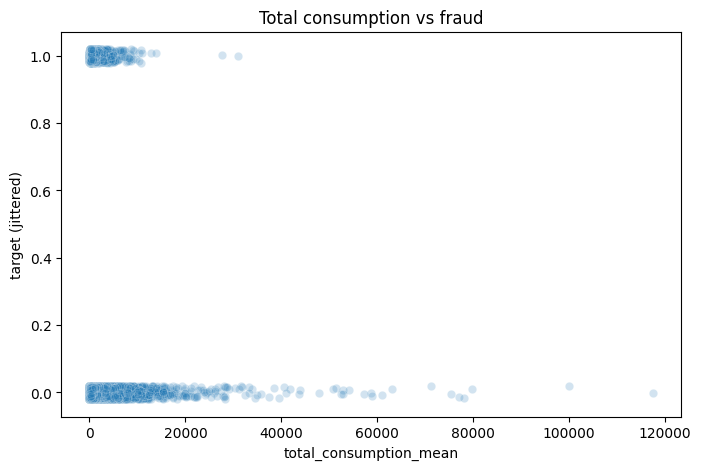

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

sns.scatterplot(
    x=df_train["total_consumption_mean"],
    y=df_train["target"] + np.random.uniform(-0.02, 0.02, size=len(df_train)),
    alpha=0.2
)

plt.xlabel("total_consumption_mean")
plt.ylabel("target (jittered)")
plt.title("Total consumption vs fraud")
plt.show()


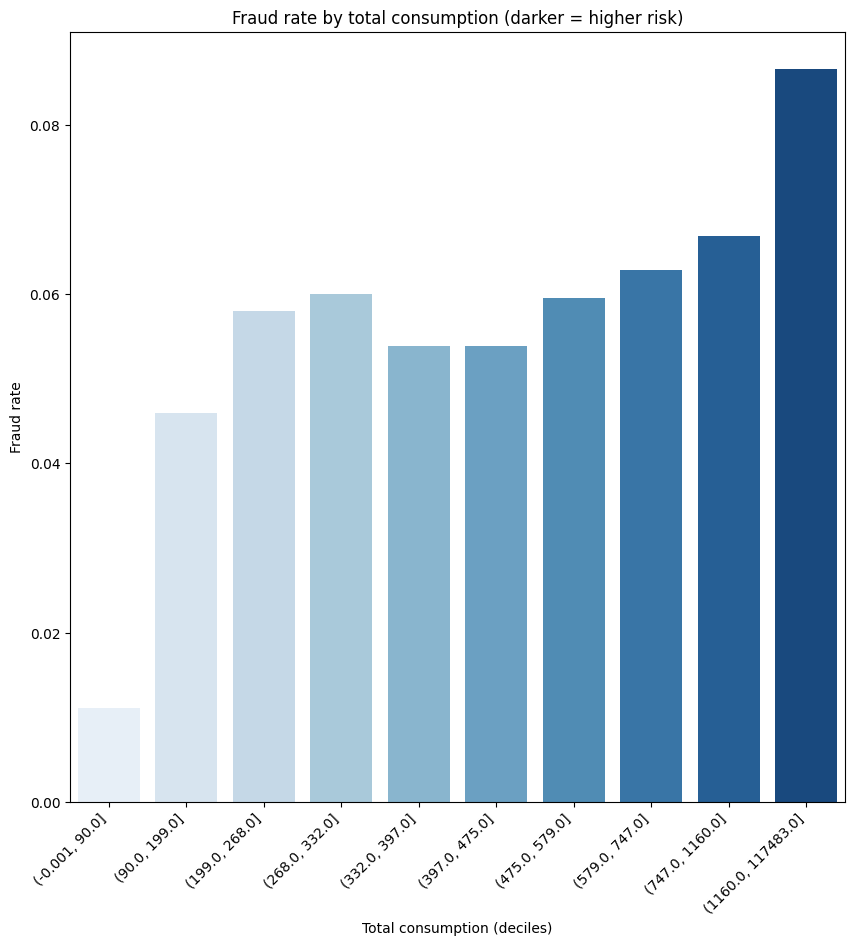

In [20]:
df_train["cons_bin"] = pd.qcut(round(df_train["total_consumption_mean"], 0), q=10, duplicates="drop")

fraud_rate_cons = (
    df_train.groupby("cons_bin")["target"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 10))

sns.barplot(
    data=fraud_rate_cons,
    x="cons_bin",
    y="target",
    palette="Blues"   # <<< sequential blue palette
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Fraud rate")
plt.xlabel("Total consumption (deciles)")
plt.title("Fraud rate by total consumption (darker = higher risk)")
plt.savefig("fraud_rate_cons.png")
plt.show()



In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101619 entries, 12402 to 107653
Data columns (total 41 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   disrict                    101619 non-null  int64   
 1   client_id                  101619 non-null  int64   
 2   client_catg                101619 non-null  int64   
 3   region                     101619 non-null  int64   
 4   creation_date              101619 non-null  object  
 5   consommation_level_1_mean  101619 non-null  float64 
 6   consommation_level_2_mean  101619 non-null  float64 
 7   consommation_level_3_mean  101619 non-null  float64 
 8   consommation_level_4_mean  101619 non-null  float64 
 9   invoice_date_min           101619 non-null  object  
 10  invoice_date_max           101619 non-null  object  
 11  invoice_date_count         101619 non-null  int64   
 12  total_consumption_mean     101619 non-null  float64 
 13  no_consumption_

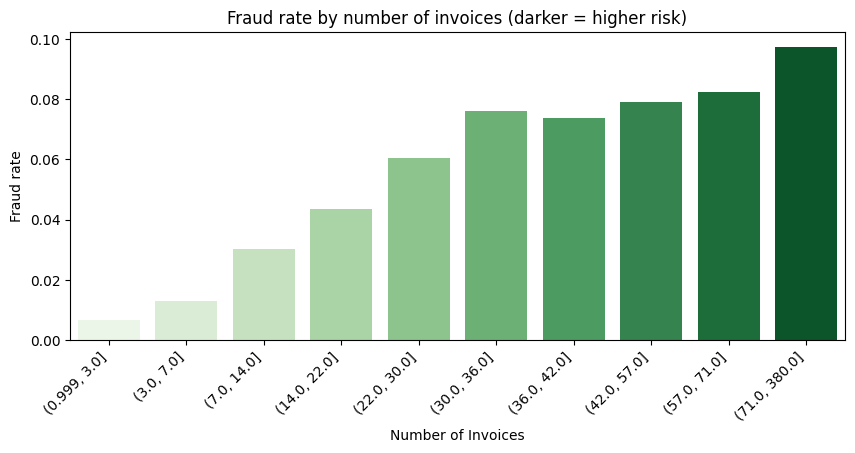

In [22]:
df_train["inv_bin"] = pd.qcut(df_train["n_invoices"], q=10, duplicates="drop")

fraud_rate_ninvoices = (
    df_train.groupby("inv_bin")["target"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))

sns.barplot(
    data=fraud_rate_ninvoices,
    x="inv_bin",
    y="target",
    palette="Greens"   # <<< sequential blue palette
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Fraud rate")
plt.xlabel("Number of Invoices")
plt.title("Fraud rate by number of invoices (darker = higher risk)")
plt.savefig("fraud_rate_invoce.png")
plt.show()


In [23]:
df_train.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean',
       'invoice_date_min', 'invoice_date_max', 'invoice_date_count',
       'total_consumption_mean', 'no_consumption_flag', 'n_invoices',
       'first_invoice', 'last_invoice', 'meter_delta_mean',
       'meter_delta_median', 'meter_delta_std', 'delta_per_month_mean',
       'delta_per_month_std', 'n_nonpositive_delta', 'n_zero_delta',
       'first_old_index', 'last_new_index', 'index_range', 'invoice_span_days',
       'coef_value', 'coef_nunique', 'coef_changed', 'code_nunique',
       'code_mode', 'code_last', 'remark_nunique', 'remark_mode',
       'remark_last', 'counter_type', 'counter_type2', 'target', 'cons_bin',
       'inv_bin'],
      dtype='object')

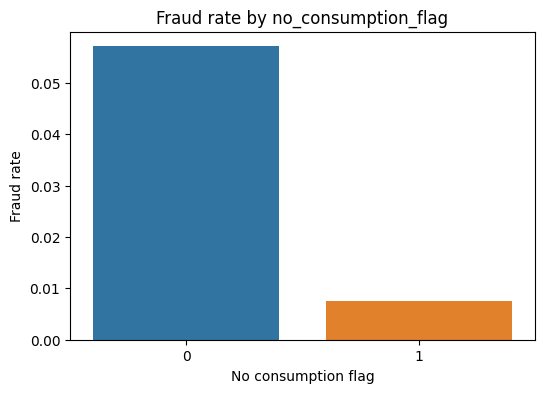

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

fraud_rate = (
    df_train
    .groupby("no_consumption_flag")["target"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=fraud_rate,
    x="no_consumption_flag",
    y="target"
)

plt.ylabel("Fraud rate")
plt.xlabel("No consumption flag")
plt.title("Fraud rate by no_consumption_flag")
plt.savefig("Fraud rate by no_consumption_flag")
plt.show()


In [25]:
df_train.groupby("no_consumption_flag")["target"].sum()

no_consumption_flag
0    5654.0
1      20.0
Name: target, dtype: float64

In [26]:
df_train["no_consumption_flag"].value_counts()

no_consumption_flag
0    98975
1     2644
Name: count, dtype: int64

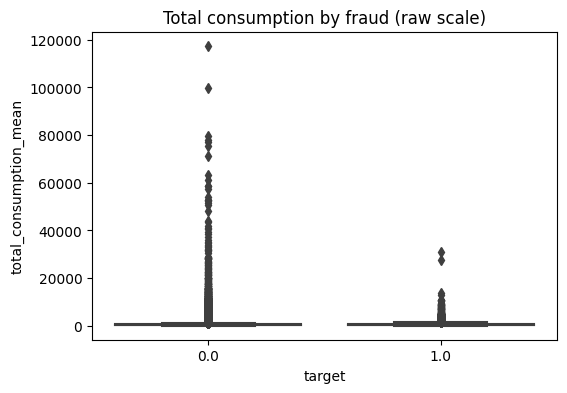

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(
    x="target",
    y="total_consumption_mean",
    data=df_train
)
plt.title("Total consumption by fraud (raw scale)")
plt.show()
#we'll take log of  it, zero con as a binary and also bins


In [28]:
bins = pd.qcut(
    df_train["total_consumption_mean"],
    q=10,                 # 10 bins = deciles
    duplicates="drop"
)

df_train.groupby(bins)["target"].agg(
    fraud_rate="mean",
    count="size"
)
#Fraud risk increases with total consumption, but non-linearly and with regimes. this produces low corr but there is a nonlinear pattern
#weak at very low consumption, flat-ish in the middle, strong at high consumption

,fraud_rate,count
total_consumption_mean,,
"(-0.001, 89.878]",0.011021,10162
"(89.878, 198.92]",0.045562,10162
"(198.92, 268.357]",0.058349,10163
"(268.357, 331.557]",0.060427,10161
"(331.557, 397.0]",0.053610,10166
"(397.0, 475.03]",0.053362,10157
"(475.03, 578.896]",0.059732,10162
"(578.896, 746.95]",0.062881,10162
"(746.95, 1159.576]",0.066818,10162


From the raw-scale boxplot:

Extreme right tail (very large consumption values)

Most observations compressed near zero

Heavy overlap between fraud (target=1) and non-fraud (target=0)

Fraud cases do not shift the mean much, but differ in where they concentrate

This combination guarantees:

Very low Pearson correlation
because correlation is driven by:

means

linear trends

symmetric distributions

None of which apply here.

In [29]:
#df_train["log_total_consumption"] = np.log1p(df_train["total_consumption_mean"])

In [30]:
#X_train["log_total_consumption"] = np.log1p(X_train["total_consumption_mean"])

## Highly correlated columns with target:
- n_invoices

More invoices → more interactions → more opportunity to exploit

- invoice_span_days

Longer billing span → prolonged relationship → exposure effect

- code_nunique

Many different codes → unusual or complex behavior

- remark_nunique

Many remarks → manual intervention, irregularities ==> research suggests that these are classic fraud signals.

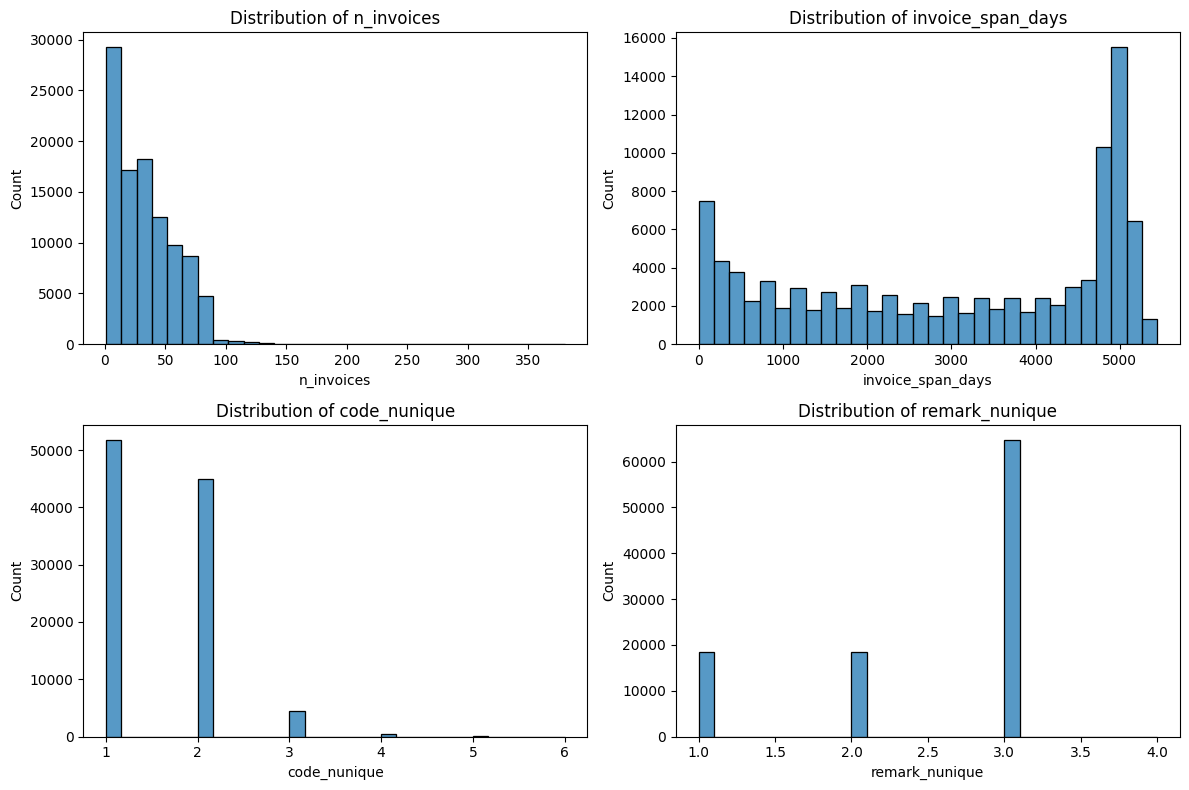

In [31]:
features = [

    "n_invoices",
    "invoice_span_days",
    "code_nunique",
    "remark_nunique"
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, features):
    sns.histplot(df_train[col], bins=30, ax=ax)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

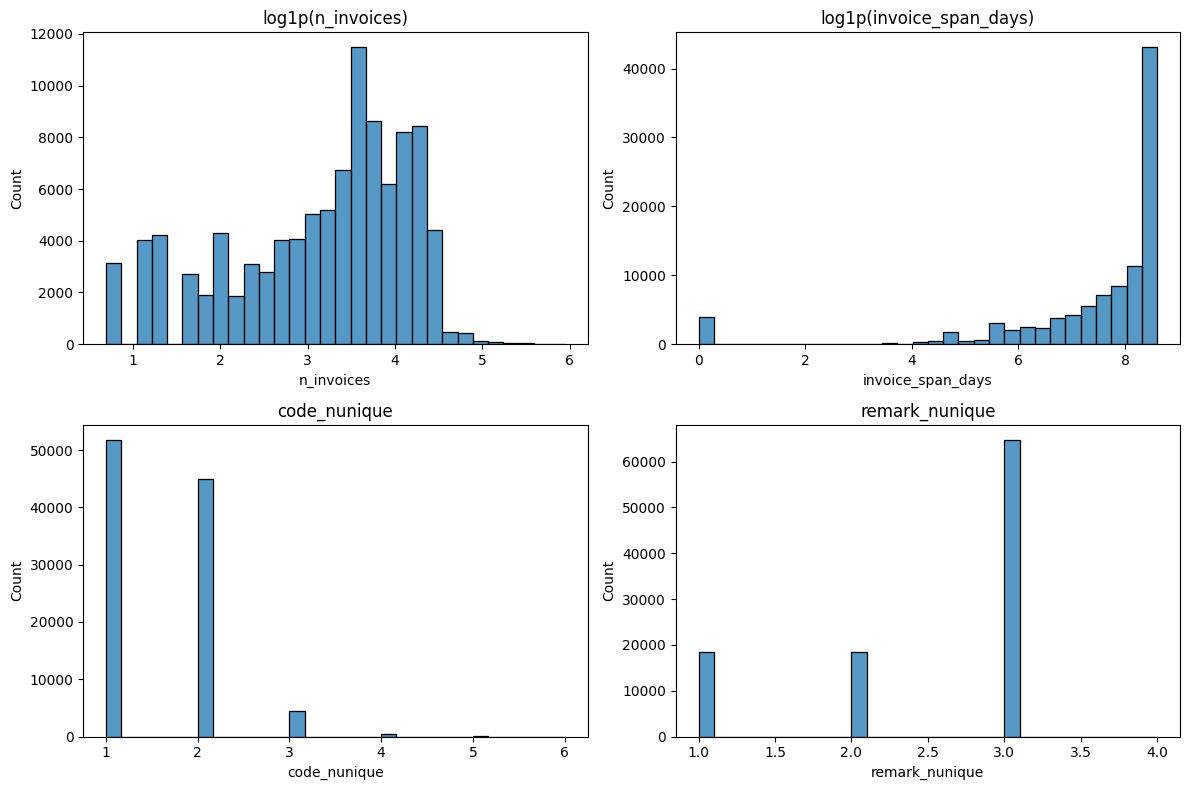

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, features):
    data = np.log1p(df_train[col]) if col in ["n_invoices", "invoice_span_days"] else df_train[col]
    sns.histplot(data, bins=30, ax=ax)
    ax.set_title(f"{'log1p(' + col + ')' if col in ['n_invoices','invoice_span_days'] else col}")

plt.tight_layout()
plt.show()


In [33]:
# Due to the distribution of these 4 columns, I'll keep code and remark numbers as they are, 
# and take log transformation of n_invoices and invoice_span_days

In [34]:
cols = df_train.columns

for col in cols:
    num_zeros = (df_train[col] == 0).sum()
    print(col, num_zeros)


disrict 0
client_id 1
client_catg 0
region 0
creation_date 0
consommation_level_1_mean 2644
consommation_level_2_mean 43841
consommation_level_3_mean 72037
consommation_level_4_mean 87885
invoice_date_min 0
invoice_date_max 0
invoice_date_count 0
total_consumption_mean 2644
no_consumption_flag 98975
n_invoices 0
first_invoice 0
last_invoice 0
meter_delta_mean 2664
meter_delta_median 6981
meter_delta_std 4920
delta_per_month_mean 2664
delta_per_month_std 4921
n_nonpositive_delta 45574
n_zero_delta 46164
first_old_index 31776
last_new_index 3738
index_range 4024
invoice_span_days 3917
coef_value 0
coef_nunique 0
coef_changed 101587
code_nunique 0
code_mode 2
code_last 2
remark_nunique 0
remark_mode 0
remark_last 0
counter_type 0
counter_type2 0
target 95945
cons_bin 0
inv_bin 0


In [35]:
df_train.groupby("no_consumption_flag")["target"].agg(
    rate="mean",
    count="size"
)

#so fraud is low among no consumption

,rate,count
no_consumption_flag,,
0,0.057126,98975
1,0.007564,2644


In [36]:
df_train.pivot_table(
    index="counter_type2",
    columns="no_consumption_flag",
    values="target",
    aggfunc="count"
)

no_consumption_flag,0,1
counter_type2,,
1,84134,2331
2,14841,313


In [37]:
df_train['target'].value_counts()

target
0.0    95945
1.0     5674
Name: count, dtype: int64

In [38]:
df_train.groupby("no_consumption_flag")["target"].sum()


no_consumption_flag
0    5654.0
1      20.0
Name: target, dtype: float64

In [39]:
df_train.groupby("target")["no_consumption_flag"].sum()

target
0.0    2624
1.0      20
Name: no_consumption_flag, dtype: int64

In [40]:
df_train.groupby("counter_type2")["target"].sum() #most of the fraud happens in ELEC bills

counter_type2
1    4635.0
2    1039.0
Name: target, dtype: float64

In [41]:
#mask = np.triu(correlations)
#sns.heatmap(correlations , vmax=1, vmin=-1, annot=True, mask=mask, cmap="YlGnBu",);

In [42]:
#Geo columns
disrict_stats = df_train.groupby("disrict")["target"].agg(
    fraud_rate="mean",
    fraud_count="sum",
    total="size"
).sort_values("fraud_rate", ascending=False)

disrict_stats
#we can create ordinal feature based on fraud rate

,fraud_rate,fraud_count,total
disrict,,,
69,0.071217,1828.0,25668
63,0.065388,1425.0,21793
62,0.051873,1570.0,30266
60,0.035619,851.0,23892


district_map = {
    60: 0,  # lowest risk
    62: 1,
    63: 2,
    69: 3   # highest risk
}

df_train["district_ord"] = df_train["disrict"].map(district_map)

In [43]:
#df_train.groupby("region")["target"].sum().sort_values() 

In [44]:
region_stats = df_train.groupby("region")["target"].agg(
    fraud_rate="mean",
    fraud_count="sum",
    total="size"
).sort_values("fraud_count", ascending=False)

region_stats
# 3 regions has 41% of frauds, 4 has 59.5% of frauds, however fraud rates are low in these region as the population is high as well.
# only 103 highest risk, 
# 311 high rate + high count
# Regions 107 / 104 / 303 — mid-risk
#Regions 101 / 301 — low risk
#Large exposure (esp. 101)
#Low fraud rate
#Important control regions
#if we will use region we should use it in its relationship with population intensivy and fraud_rate

,fraud_rate,fraud_count,total
region,,,
101,0.035678,902.0,25282
311,0.080581,754.0,9357
103,0.103330,692.0,6697
104,0.055510,537.0,9674
107,0.065464,490.0,7485
303,0.054889,247.0,4500
301,0.032601,233.0,7147
306,0.046778,212.0,4532
304,0.070200,200.0,2849


small_regions = df_train.groupby("region").size()
small_regions = small_regions[small_regions < 1000].index

df_train["region_grouped"] = df_train["region"].where(
    ~df_train["region"].isin(small_regions),
    "OTHER"
)

#we order region by using their pop size and fraud rate
region_order = (
    df_train
    .groupby("region_grouped")["target"]
    .mean()
    .sort_values()
    .index
)
region_order


region_map = {r: i for i, r in enumerate(region_order)}
df_train["region_ord"] = df_train["region_grouped"].map(region_map)

In [45]:
df_train.head()

,disrict,client_id,client_catg,region,creation_date,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,invoice_date_min,...,code_mode,code_last,remark_nunique,remark_mode,remark_last,counter_type,counter_type2,target,cons_bin,inv_bin
12402,60,111158,11,101,2003-12-08,854.969697,252.060606,0.000000,0.000000,2005-09-22,...,442,442,3,6,9,ELEC,1,0.0,"(747.0, 1160.0]","(30.0, 36.0]"
113749,69,80428,11,103,2002-07-31,246.169231,0.000000,0.000000,0.000000,2006-06-09,...,203,203,3,6,6,ELEC,1,0.0,"(199.0, 268.0]","(57.0, 71.0]"
106555,62,73954,11,305,1999-12-27,845.794118,686.529412,397.470588,373.764706,2006-05-22,...,413,413,3,6,9,ELEC,1,0.0,"(1160.0, 117483.0]","(30.0, 36.0]"
53643,62,26332,11,307,1982-05-29,333.425000,12.675000,0.000000,0.000000,2005-07-12,...,203,203,3,6,8,ELEC,1,0.0,"(332.0, 397.0]","(36.0, 42.0]"
69779,69,40855,11,104,2016-12-05,150.285714,0.000000,0.000000,0.000000,2017-10-03,...,413,413,3,9,8,ELEC,1,0.0,"(90.0, 199.0]","(3.0, 7.0]"


In [46]:
#Geo columns
client_catg_stats = df_train.groupby("client_catg")["target"].agg(
    fraud_rate="mean",
    fraud_count="sum",
    total="size"
).sort_values("fraud_rate", ascending=False)

client_catg_stats
#we can create another ordinal column out of this based on risk level and pop (how common)

,fraud_rate,fraud_count,total
client_catg,,,
51,0.170612,209.0,1225
11,0.054674,5394.0,98657
12,0.040875,71.0,1737


client_catg_map = {
    12: 0,  # lowest risk
    11: 1,  # baseline
    51: 2   # high risk
}

df_train["client_catg_ord"] = df_train["client_catg"].map(client_catg_map)

In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101619 entries, 12402 to 107653
Data columns (total 42 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   disrict                    101619 non-null  int64   
 1   client_id                  101619 non-null  int64   
 2   client_catg                101619 non-null  int64   
 3   region                     101619 non-null  int64   
 4   creation_date              101619 non-null  object  
 5   consommation_level_1_mean  101619 non-null  float64 
 6   consommation_level_2_mean  101619 non-null  float64 
 7   consommation_level_3_mean  101619 non-null  float64 
 8   consommation_level_4_mean  101619 non-null  float64 
 9   invoice_date_min           101619 non-null  object  
 10  invoice_date_max           101619 non-null  object  
 11  invoice_date_count         101619 non-null  int64   
 12  total_consumption_mean     101619 non-null  float64 
 13  no_consumption_

In [48]:
df_train.head()

,disrict,client_id,client_catg,region,creation_date,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,invoice_date_min,...,code_mode,code_last,remark_nunique,remark_mode,remark_last,counter_type,counter_type2,target,cons_bin,inv_bin
12402,60,111158,11,101,2003-12-08,854.969697,252.060606,0.000000,0.000000,2005-09-22,...,442,442,3,6,9,ELEC,1,0.0,"(747.0, 1160.0]","(30.0, 36.0]"
113749,69,80428,11,103,2002-07-31,246.169231,0.000000,0.000000,0.000000,2006-06-09,...,203,203,3,6,6,ELEC,1,0.0,"(199.0, 268.0]","(57.0, 71.0]"
106555,62,73954,11,305,1999-12-27,845.794118,686.529412,397.470588,373.764706,2006-05-22,...,413,413,3,6,9,ELEC,1,0.0,"(1160.0, 117483.0]","(30.0, 36.0]"
53643,62,26332,11,307,1982-05-29,333.425000,12.675000,0.000000,0.000000,2005-07-12,...,203,203,3,6,8,ELEC,1,0.0,"(332.0, 397.0]","(36.0, 42.0]"
69779,69,40855,11,104,2016-12-05,150.285714,0.000000,0.000000,0.000000,2017-10-03,...,413,413,3,9,8,ELEC,1,0.0,"(90.0, 199.0]","(3.0, 7.0]"


## Summary of EDA
- Main Features and how they should enter the model: 
    * client_catg_ord: ordinal column created (0 'low risk', 1 'baseline (high pop, mean risk)', 2 'high risk (low pop, high fraud rate)')
    * region_ord: ordinal column for region created based on population share and fraud rate
    * district_ord    60: 0,  # lowest risk, 62: 1, 63: 2, 69: 3   # highest risk
    * log(total_consumption_mean)
    * invoice_span_days: we may create bins as 1 year, 2 years etc
    * nu_invoice
    * remark_nunique
    * code_nunique
    


In [49]:
df_train.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean',
       'invoice_date_min', 'invoice_date_max', 'invoice_date_count',
       'total_consumption_mean', 'no_consumption_flag', 'n_invoices',
       'first_invoice', 'last_invoice', 'meter_delta_mean',
       'meter_delta_median', 'meter_delta_std', 'delta_per_month_mean',
       'delta_per_month_std', 'n_nonpositive_delta', 'n_zero_delta',
       'first_old_index', 'last_new_index', 'index_range', 'invoice_span_days',
       'coef_value', 'coef_nunique', 'coef_changed', 'code_nunique',
       'code_mode', 'code_last', 'remark_nunique', 'remark_mode',
       'remark_last', 'counter_type', 'counter_type2', 'target', 'cons_bin',
       'inv_bin'],
      dtype='object')

## We create a function called feature_engineering to create new features in X_train and X_test

In [50]:
import numpy as np

def feature_engineering(df, region_map, small_regions):
    df= df.copy()

    # log consumption
    df["log_total_consumption"] = np.log1p(df["total_consumption_mean"])

    # district ordinal
    district_map = {60: 0, 62: 1, 63: 2, 69: 3}
    df["district_ord"] = df["disrict"].map(district_map)

    # client category ordinal
    client_catg_map = {12: 0, 11: 1, 51: 2}
    df["client_catg_ord"] = df["client_catg"].map(client_catg_map)

    # region grouped + ordinal
    df["region_grouped"] = df["region"].where(
        ~df["region"].isin(small_regions), "OTHER"
    )
    df["region_ord"] = df["region_grouped"].map(region_map)

    return df


In [51]:
# small regions (in terms of client number) on train only
region_counts = X_train["region"].value_counts()
small_regions = region_counts[region_counts < 1000].index

# grouping regions based on size
region_grouped = X_train["region"].where(
    ~X_train["region"].isin(small_regions), "OTHER"
)

# order regions by fraud rate
y_train_1d = y_train.squeeze()
region_order = (
    pd.DataFrame({"region_grouped": region_grouped, "target": y_train_1d})
    .groupby("region_grouped")["target"]
    .mean()
    .sort_values()
    .index
)

region_map = {r: i for i, r in enumerate(region_order)}


In [52]:
df_train_fe=feature_engineering(df_train, region_map, small_regions)

## Visuals with created features

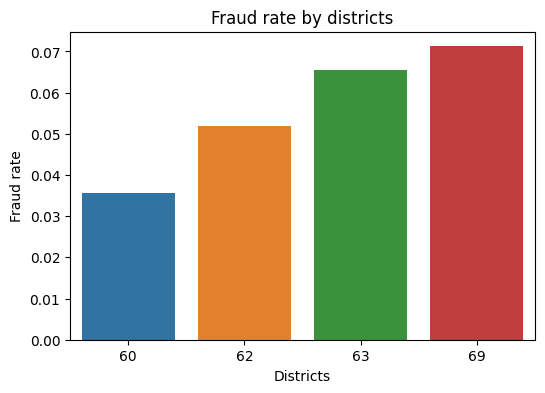

In [53]:
fraud_rate_dist = (
    df_train_fe
    .groupby("disrict")["target"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=fraud_rate_dist,
    x="disrict",
    y="target"
)

plt.ylabel("Fraud rate")
plt.xlabel("Districts")
plt.title("Fraud rate by districts")
plt.savefig("fraud_rate_dist")
plt.show()


fraud_rate_region = (
    df_train_fe
    .groupby("region")["target"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=fraud_rate_region,
    x="region",
    y="target",
    palette="Reds" 
)

plt.ylabel("Fraud rate")
plt.xlabel("Regions")
plt.title("Fraud rate by regions")
plt.savefig("fraud_rate_region")
plt.show()

code_nunique

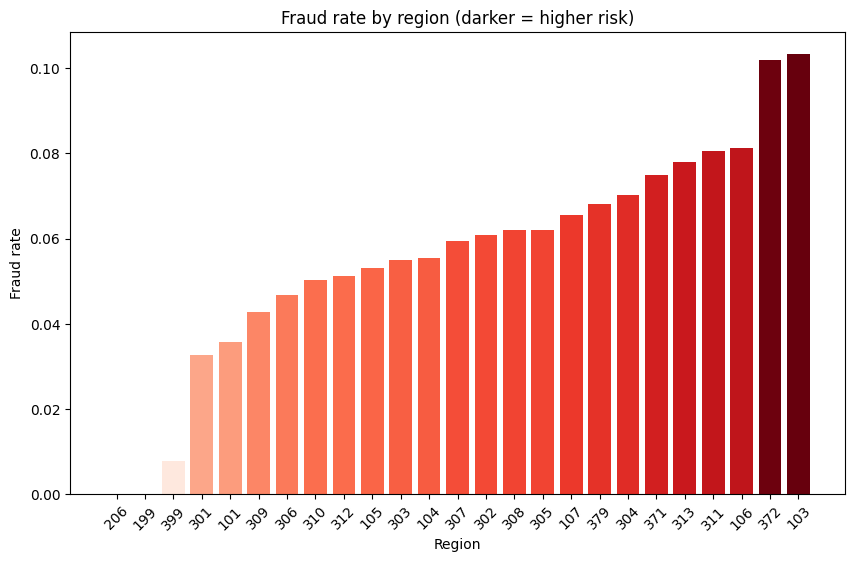

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# compute fraud rate
fraud_rate_region = (
    df_train_fe
    .groupby("region")["target"]
    .mean()
    .reset_index()
)

# sort regions by fraud rate (important for interpretation)
fraud_rate_region = fraud_rate_region.sort_values("target")

# normalize fraud rate for color mapping
norm = plt.Normalize(
    fraud_rate_region["target"].min(),
    fraud_rate_region["target"].max()
)

colors = plt.cm.Reds(norm(fraud_rate_region["target"]))

plt.figure(figsize=(10, 6))
plt.bar(
    fraud_rate_region["region"].astype(str),
    fraud_rate_region["target"],
    color=colors
)

plt.ylabel("Fraud rate")
plt.xlabel("Region")
plt.title("Fraud rate by region (darker = higher risk)")
plt.xticks(rotation=45)
plt.savefig("fraud_rate_region.png", dpi=300, bbox_inches="tight")
plt.show()


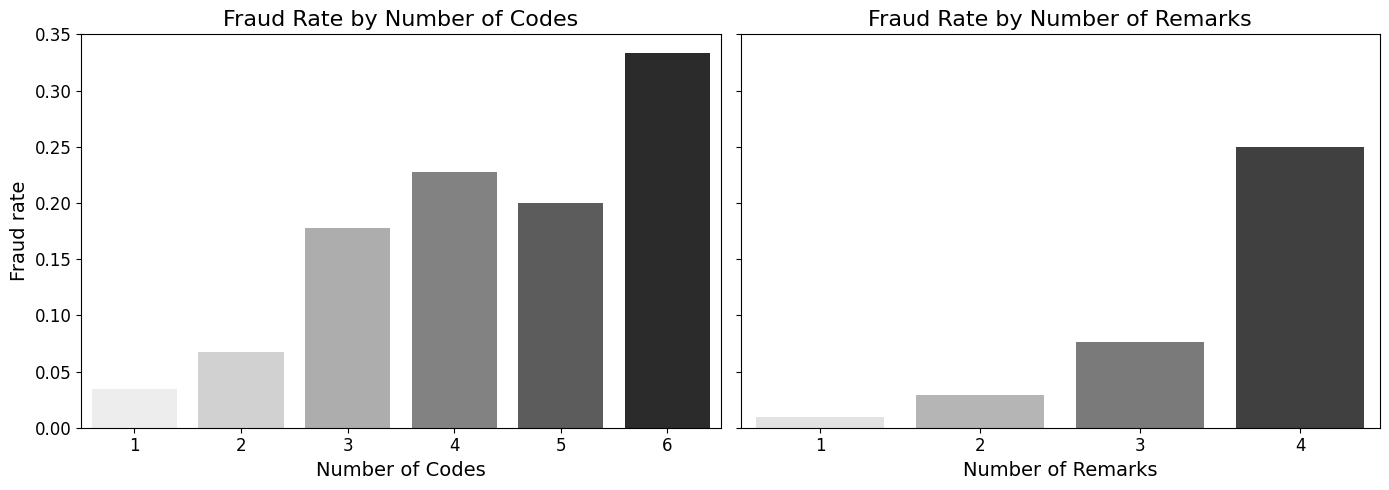

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fraud_rate_code_nunique = (
    df_train_fe
    .groupby("code_nunique")["target"]
    .mean()
    .reset_index()
)
# Code nunique 
sns.barplot(
    data=fraud_rate_code_nunique,
    x="code_nunique",
    y="target",
    palette="Greys",
    ax=axes[0]
)
axes[0].set_title("Fraud Rate by Number of Codes", fontsize=16)
axes[0].set_xlabel("Number of Codes", fontsize=14)
axes[0].set_ylabel("Fraud rate", fontsize=14)
axes[0].tick_params(axis="both", labelsize=12)

# Remark nunique 
fraud_rate_remark_nunique = (
    df_train_fe
    .groupby("remark_nunique")["target"]
    .mean()
    .reset_index()
)
sns.barplot(
    data=fraud_rate_remark_nunique,
    x="remark_nunique",
    y="target",
    palette="Greys",
    ax=axes[1]
)
axes[1].set_title("Fraud Rate by Number of Remarks", fontsize=16)
axes[1].set_xlabel("Number of Remarks", fontsize=14)
axes[1].set_ylabel("")  # shared y-axis
axes[1].tick_params(axis="both", labelsize=12)

plt.tight_layout()
plt.savefig("fraud_rate_code_vs_remark_nunique.png", dpi=300, bbox_inches="tight")
plt.show()


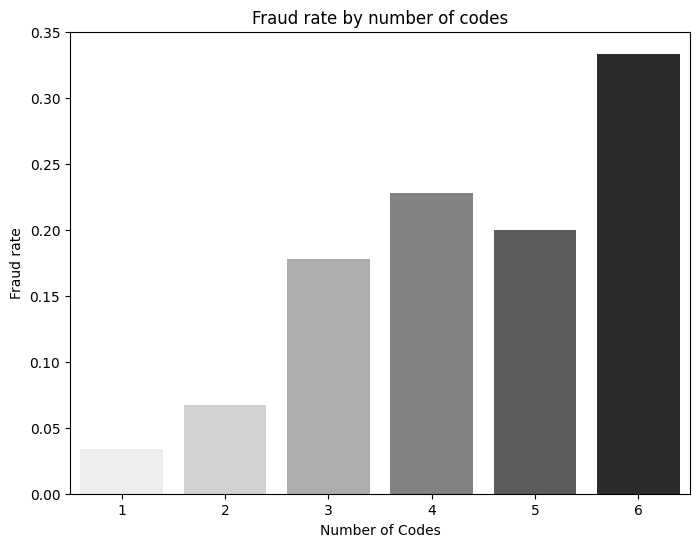

In [56]:
fraud_rate_code_nunique = (
    df_train_fe
    .groupby("code_nunique")["target"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=fraud_rate_code_nunique,
    x="code_nunique",
    y="target",
    palette="Greys" 
)

plt.ylabel("Fraud rate")
plt.xlabel("Number of Codes")
plt.title("Fraud rate by number of codes")
plt.savefig("fraud_rate_code_nunique")
plt.show()



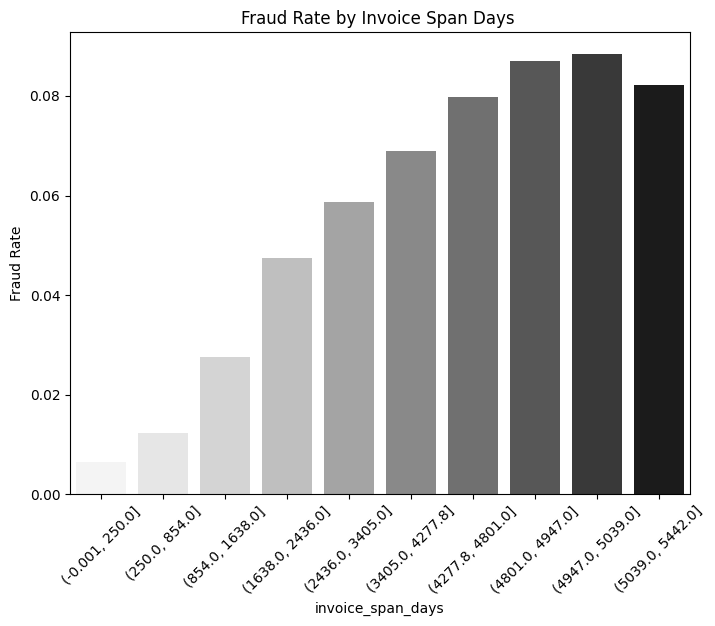

In [57]:
df_train_fe["bin_inv_span_days"] = pd.qcut(df_train_fe["invoice_span_days"], q=10, duplicates="drop")
fraud_rate_invoice_span_days = (
    df_train_fe
    .groupby("bin_inv_span_days")["target"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=fraud_rate_invoice_span_days,
    x="bin_inv_span_days",
    y="target",
    palette="Greys" 
)

plt.ylabel("Fraud Rate")
plt.xlabel("invoice_span_days")
plt.xticks(rotation=45)
plt.title("Fraud Rate by Invoice Span Days ")
plt.savefig("fraud_rate_invoice_span_days ")
plt.show()

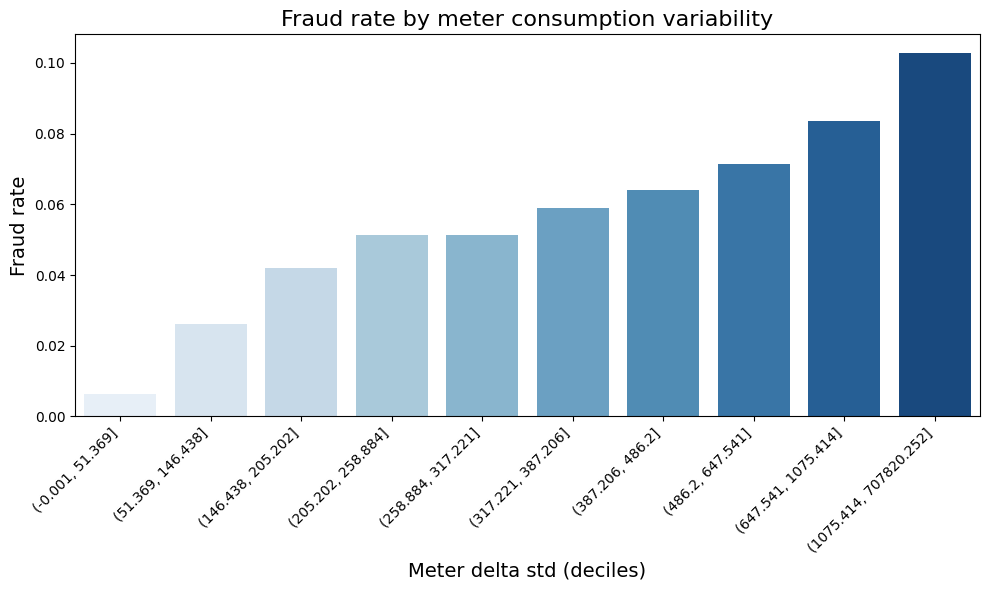

In [65]:
from pandas import qcut
# bin meter_delta_std into deciles
df_train_fe["meter_delta_std_bin"] = pd.qcut(
    df_train_fe["meter_delta_std"],
    q=10,
    duplicates="drop"
)

fraud_rate_meter_std = (
    df_train_fe
    .groupby("meter_delta_std_bin")["target"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=fraud_rate_meter_std,
    x="meter_delta_std_bin",
    y="target",
    palette="Blues"
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Meter delta std (deciles)", fontsize=14)
plt.ylabel("Fraud rate", fontsize=14)
plt.title("Fraud rate by meter consumption variability", fontsize=16)
plt.tight_layout()
plt.savefig("Fraud rate by meter consumption variability")
plt.show()


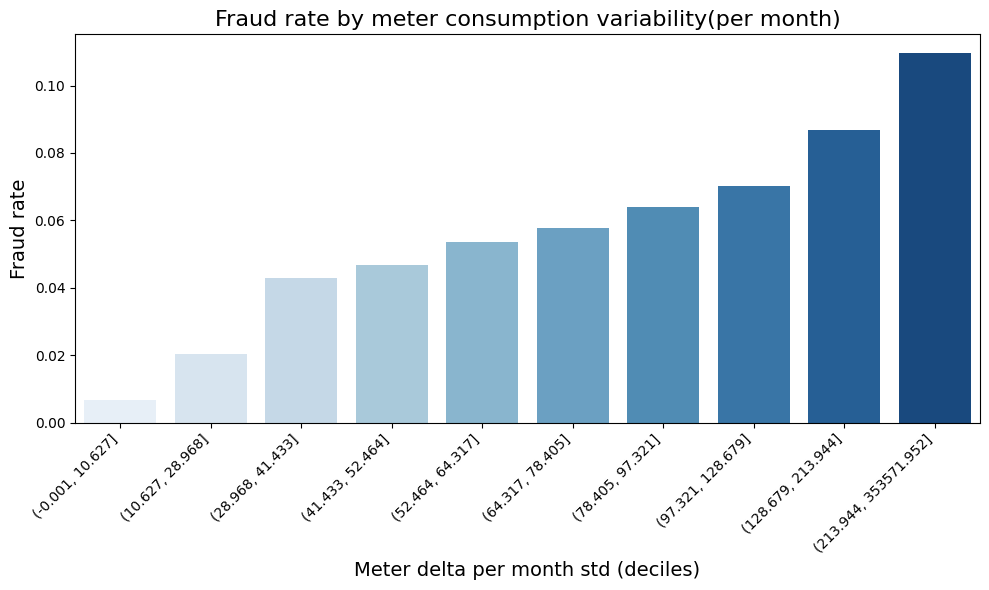

In [64]:
# meter_delta_month_std_bin into deciles
df_train_fe["meter_delta_month_std_bin"] =qcut(
    df_train_fe["delta_per_month_std"],
    q=10,
    duplicates="drop"
)

fraud_rate_meter_std = (
    df_train_fe
    .groupby("meter_delta_month_std_bin")["target"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=fraud_rate_meter_std,
    x="meter_delta_month_std_bin",
    y="target",
    palette="Blues"
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Meter delta per month std (deciles)", fontsize=14)
plt.ylabel("Fraud rate", fontsize=14)
plt.title("Fraud rate by meter consumption variability(per month)", fontsize=16)
plt.tight_layout()
plt.savefig("Fraud rate by meter consumption variability(per month)")
plt.show()

In [60]:
df_train_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101619 entries, 12402 to 107653
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   disrict                    101619 non-null  int64   
 1   client_id                  101619 non-null  int64   
 2   client_catg                101619 non-null  int64   
 3   region                     101619 non-null  int64   
 4   creation_date              101619 non-null  object  
 5   consommation_level_1_mean  101619 non-null  float64 
 6   consommation_level_2_mean  101619 non-null  float64 
 7   consommation_level_3_mean  101619 non-null  float64 
 8   consommation_level_4_mean  101619 non-null  float64 
 9   invoice_date_min           101619 non-null  object  
 10  invoice_date_max           101619 non-null  object  
 11  invoice_date_count         101619 non-null  int64   
 12  total_consumption_mean     101619 non-null  float64 
 13  no_consumption_

In [61]:
X_train=feature_engineering(X_train, region_map, small_regions)

In [62]:
X_test=feature_engineering(X_test, region_map, small_regions)

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101619 entries, 12402 to 107653
Data columns (total 44 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   disrict                    101619 non-null  int64  
 1   client_id                  101619 non-null  int64  
 2   client_catg                101619 non-null  int64  
 3   region                     101619 non-null  int64  
 4   creation_date              101619 non-null  object 
 5   consommation_level_1_mean  101619 non-null  float64
 6   consommation_level_2_mean  101619 non-null  float64
 7   consommation_level_3_mean  101619 non-null  float64
 8   consommation_level_4_mean  101619 non-null  float64
 9   invoice_date_min           101619 non-null  object 
 10  invoice_date_max           101619 non-null  object 
 11  invoice_date_count         101619 non-null  int64  
 12  total_consumption_mean     101619 non-null  float64
 13  no_consumption_flag        101

In [64]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33874 entries, 55911 to 120685
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   disrict                    33874 non-null  int64  
 1   client_id                  33874 non-null  int64  
 2   client_catg                33874 non-null  int64  
 3   region                     33874 non-null  int64  
 4   creation_date              33874 non-null  object 
 5   consommation_level_1_mean  33874 non-null  float64
 6   consommation_level_2_mean  33874 non-null  float64
 7   consommation_level_3_mean  33874 non-null  float64
 8   consommation_level_4_mean  33874 non-null  float64
 9   invoice_date_min           33874 non-null  object 
 10  invoice_date_max           33874 non-null  object 
 11  invoice_date_count         33874 non-null  int64  
 12  total_consumption_mean     33874 non-null  float64
 13  no_consumption_flag        33874 non-null  int

In [65]:
X_train_basefe=X_train[['client_id', 'total_consumption_mean', 'no_consumption_flag', 'n_invoices',
        'meter_delta_median', 'meter_delta_std', 'delta_per_month_mean',
       'delta_per_month_std', 'invoice_span_days', 'coef_value', 'coef_nunique', 'coef_changed', 'code_nunique',
     'remark_nunique', 'remark_mode', 'counter_type2', 'region_ord', 'client_catg_ord', 'district_ord',
       'log_total_consumption']]

In [66]:
X_test_basefe=X_test[['client_id', 'total_consumption_mean', 'no_consumption_flag', 'n_invoices',
        'meter_delta_median', 'meter_delta_std', 'delta_per_month_mean',
       'delta_per_month_std', 'invoice_span_days', 'coef_value', 'coef_nunique', 'coef_changed', 'code_nunique',
     'remark_nunique', 'remark_mode', 'counter_type2', 'region_ord', 'client_catg_ord', 'district_ord',
       'log_total_consumption']]

In [67]:
X_test_basefe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33874 entries, 55911 to 120685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               33874 non-null  int64  
 1   total_consumption_mean  33874 non-null  float64
 2   no_consumption_flag     33874 non-null  int64  
 3   n_invoices              33874 non-null  int64  
 4   meter_delta_median      33874 non-null  float64
 5   meter_delta_std         33874 non-null  float64
 6   delta_per_month_mean    33874 non-null  float64
 7   delta_per_month_std     33874 non-null  float64
 8   invoice_span_days       33874 non-null  int64  
 9   coef_value              33874 non-null  int64  
 10  coef_nunique            33874 non-null  int64  
 11  coef_changed            33874 non-null  int64  
 12  code_nunique            33874 non-null  int64  
 13  remark_nunique          33874 non-null  int64  
 14  remark_mode             33874 non-null

# Base Model: Dummy Classifier

In [68]:
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="prior") 
dummy.fit(X_train_basefe, y_train)

DummyClassifier()

In [69]:
# class predictions (0 / 1)
y_preddummy = dummy.predict(X_test_basefe)

# predicted probabilities for the positive class (fraud = 1)
y_probadummy = dummy.predict_proba(X_test_basefe)[:, 1]


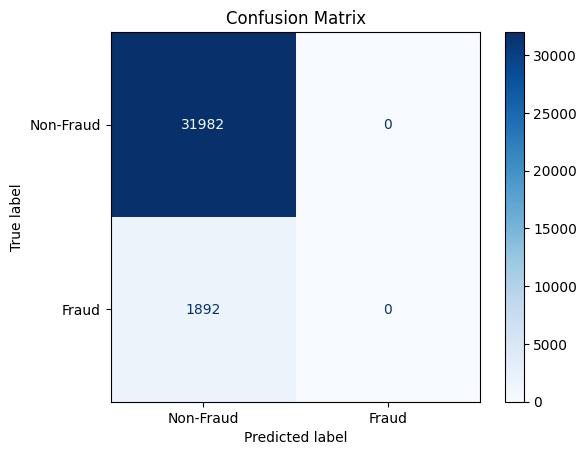

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_preddummy)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Fraud", "Fraud"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [71]:
y_test.target.value_counts()

target
0.0    31982
1.0     1892
Name: count, dtype: int64

In [72]:
# Print classification report of our model

print(classification_report(y_test, y_preddummy))
print("--------"*10)

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     31982
         1.0       0.00      0.00      0.00      1892

    accuracy                           0.94     33874
   macro avg       0.47      0.50      0.49     33874
weighted avg       0.89      0.94      0.92     33874

--------------------------------------------------------------------------------


In [73]:
roc_auc = roc_auc_score(y_test, y_probadummy)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.5000


# Logistic Regression without class_weight=balanced (before balancing)

In [74]:
X_train_logbase=X_train[['client_id', 'no_consumption_flag', 'log_total_consumption', 'n_invoices', 'district_ord']]
X_test_logbase=X_test[['client_id', 'no_consumption_flag', 'log_total_consumption', 'n_invoices', 'district_ord']]

In [75]:
# Modelling
# Train Logistic Regression
log_reg_base = LogisticRegression(max_iter=1000)
log_reg_base.fit(X_train_logbase, y_train)

# class predictions (0 / 1)
y_pred_train_base = log_reg_base.predict(X_train_logbase)
y_pred_test_base = log_reg_base.predict(X_test_logbase)
# predicted probabilities for the positive class (fraud = 1)
y_proba_base = log_reg_base.predict_proba(X_test_logbase)[:, 1]

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train_base), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test_base), 2))
print("--------"*10)

Accuracy on train set: 0.94
Accuracy on test set: 0.94
--------------------------------------------------------------------------------


In [76]:
# Print classification report of our model
print(classification_report(y_test, y_pred_test_base))
print("--------"*10)

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     31982
         1.0       0.00      0.00      0.00      1892

    accuracy                           0.94     33874
   macro avg       0.47      0.50      0.49     33874
weighted avg       0.89      0.94      0.92     33874

--------------------------------------------------------------------------------


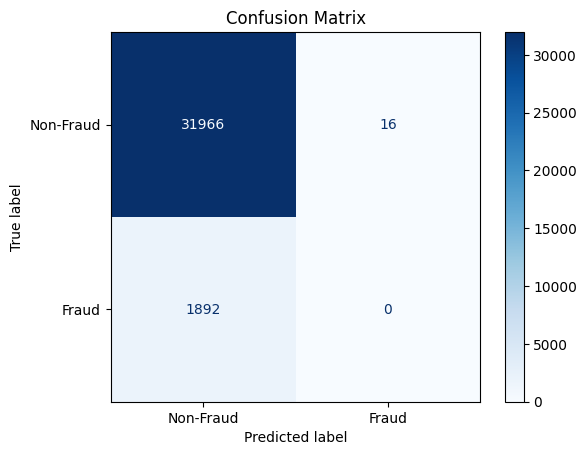

In [77]:
# Confusion matrix using pandas crosstab
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test_base)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Fraud", "Fraud"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [78]:
roc_auc = roc_auc_score(y_test, y_proba_base)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.5069


# Logistic Regression with class_weight=balanced (before balancing)

In [79]:
#to deal with unbalanced target dist: pip install imbalanced-learn
#from imblearn.pipeline import make_pipeline as imb_pipe

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [81]:
# Modelling
# Train Logistic Regression
log_reg_bbase = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_bbase.fit(X_train_logbase, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [82]:
# class predictions (0 / 1)
y_pred_train_bbase = log_reg_bbase.predict(X_train_logbase)
y_pred_test_bbase = log_reg_bbase.predict(X_test_logbase)
# predicted probabilities for the positive class (fraud = 1)
y_proba_bbase = log_reg_bbase.predict_proba(X_test_logbase)[:, 1]

In [83]:
# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train_bbase), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test_bbase), 2))
print("--------"*10)

Accuracy on train set: 0.5
Accuracy on test set: 0.51
--------------------------------------------------------------------------------


In [84]:
# Print classification report of our model
print(classification_report(y_test, y_pred_test_bbase))
print("--------"*10)

              precision    recall  f1-score   support

         0.0       0.97      0.50      0.66     31982
         1.0       0.08      0.70      0.14      1892

    accuracy                           0.51     33874
   macro avg       0.52      0.60      0.40     33874
weighted avg       0.92      0.51      0.63     33874

--------------------------------------------------------------------------------


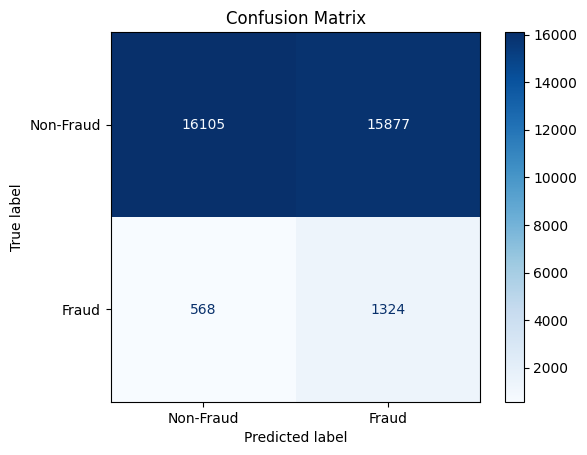

In [85]:
# Confusion matrix using pandas crosstab
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test_bbase)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Fraud", "Fraud"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [86]:
roc_auc = roc_auc_score(y_test, y_proba_bbase)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.6395


In [87]:
from sklearn.metrics import average_precision_score

print("PR-AUC (unbalanced):",
      average_precision_score(y_test, y_proba_base))

print("PR-AUC (balanced):",
      average_precision_score(y_test, y_proba_bbase))


PR-AUC (unbalanced): 0.054718684866192364
PR-AUC (balanced): 0.09123606964457003


The balanced logistic regression substantially improves fraud recall (≈65%) at the cost of precision. 
Ranking metrics (ROC ≈ 0.69, PR-AUC ≈ 0.11) indicate stable discriminatory power. This is a solid baseline suitable for threshold optimization.

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def cm_heatmap(model, Xt, yt):
    """
    This function spits out the confusion-matrix plot for a given trained model
    """
    # predictions on test data
    yp = model.predict(Xt)

    # compute confusion matrix
    cm = confusion_matrix(yt, yp)

    # display confusion matrix
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Non-Fraud", "Fraud"]
    )

    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


In [89]:
from sklearn.metrics import roc_auc_score

def metrics(classifier_name, model, Xt, yt):
    """
    returns a dataframe with the model evaluation metrics 
    for a given trained model
    """
    yp = model.predict(Xt)

    metrics_list = [
        accuracy_score,
        precision_score,
        recall_score,
        balanced_accuracy_score
    ]
    scores = [[round(metric(yt, yp), 6)] for metric in metrics_list]

    y_proba = model.predict_proba(Xt)[:, 1]
    scores.append([round(roc_auc_score(yt, y_proba), 6)])
    metrics_list.append(roc_auc_score)

    df_metric = pd.DataFrame(
        data=dict(zip([m.__name__ for m in metrics_list], scores)),
        index=[classifier_name]
    )
    return df_metric


## Log reg without balanced class weight

In [90]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imb_pipe

In [91]:
#Features for logistic regression
X_train_lrfe=X_train_basefe[['log_total_consumption', 'no_consumption_flag', 'n_invoices', 'invoice_span_days', 'meter_delta_median', 
                    'meter_delta_std', 'delta_per_month_mean', 'delta_per_month_std', 'coef_nunique', 'coef_changed', 'code_nunique',
       'remark_nunique', 'counter_type2', 'region_ord',
       'client_catg_ord', 'district_ord']]

In [92]:
X_test_lrfe=X_test_basefe[['log_total_consumption', 'no_consumption_flag', 'n_invoices', 'invoice_span_days', 'meter_delta_median', 
                    'meter_delta_std', 'delta_per_month_mean', 'delta_per_month_std', 'coef_nunique', 'coef_changed', 'code_nunique',
       'remark_nunique', 'counter_type2', 'region_ord',
       'client_catg_ord', 'district_ord']]

In [161]:
# pipeline of logistic regression classifier without balanced class weight
lr_pipeline = make_pipeline(
    StandardScaler(with_mean=False) if hasattr(X_train_lrfe, "tocsc") else StandardScaler(),
    LogisticRegression(n_jobs=-1, max_iter=2000, solver="lbfgs")
)

In [162]:
# train model
lr_pipeline.fit(X_train_lrfe,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, n_jobs=-1))])

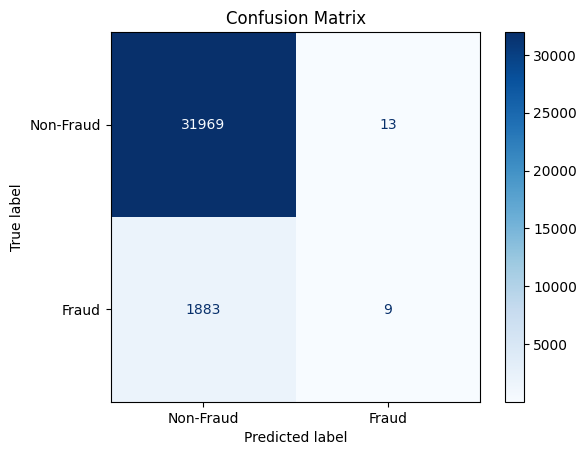

In [163]:
# confusion matrix heatmap
cm_heatmap(lr_pipeline, Xt=X_test_lrfe, yt=y_test)

In [164]:

# evaluation metric dataframe
df_unbalanced_logistic = metrics('unbalanced_logistic', lr_pipeline, Xt=X_test_lrfe, yt=y_test)
df_unbalanced_logistic

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
unbalanced_logistic,0.944028,0.409091,0.004757,0.502175,0.741213


## Log reg with balanced class weight

In [165]:
# pipeline of logistic regression classifier with balanced class weight


lrb_pipeline = make_pipeline(
    StandardScaler(with_mean=False) if hasattr(X_train_lrfe, "tocsc") else StandardScaler(),
    LogisticRegression(class_weight='balanced', n_jobs=-1, max_iter=2000, solver="lbfgs")
)




In [98]:
X_train_lrfe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101619 entries, 12402 to 107653
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   log_total_consumption  101619 non-null  float64
 1   no_consumption_flag    101619 non-null  int64  
 2   n_invoices             101619 non-null  int64  
 3   invoice_span_days      101619 non-null  int64  
 4   meter_delta_median     101619 non-null  float64
 5   meter_delta_std        101619 non-null  float64
 6   delta_per_month_mean   101619 non-null  float64
 7   delta_per_month_std    101619 non-null  float64
 8   coef_nunique           101619 non-null  int64  
 9   coef_changed           101619 non-null  int64  
 10  code_nunique           101619 non-null  int64  
 11  remark_nunique         101619 non-null  int64  
 12  counter_type2          101619 non-null  int64  
 13  region_ord             101619 non-null  int64  
 14  client_catg_ord        101619 non-nul

In [166]:
# train model
lrb_pipeline.fit(X_train_lrfe,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    n_jobs=-1))])

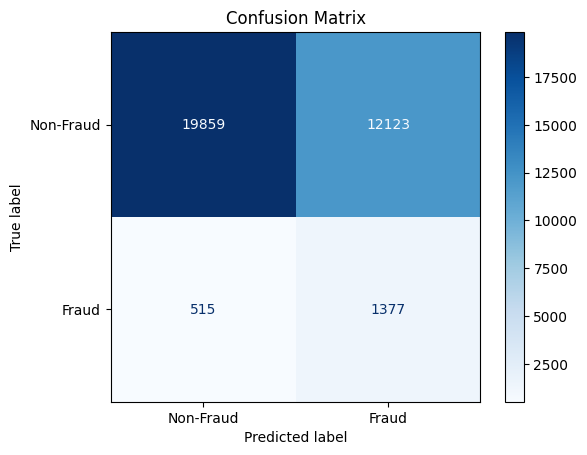

In [167]:
# confusion matrix heatmap
cm_heatmap(lrb_pipeline, Xt=X_test_lrfe, yt=y_test)


In [168]:
# evaluation metric dataframe
df_balanced_logistic = metrics('balanced_logistic', lrb_pipeline, Xt=X_test_lrfe, yt=y_test)
df_balanced_logistic

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
balanced_logistic,0.626911,0.102,0.727801,0.674372,0.74178


# Improvements 
## 3rd model- with different target balancing methods
### 3.1.1 RandomOverSampler


In [169]:
from imblearn.over_sampling import RandomOverSampler

In [170]:
# random overampling of fraud class to sample size 200_000
ros = RandomOverSampler(random_state=10, sampling_strategy={1: 200_000}) 

# pipeline
ros_pipeline = imb_pipe(ros, lr_pipeline)

In [171]:
# train model
ros_pipeline.fit(X_train_lrfe,y_train)

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=10,
                                   sampling_strategy={1: 200000})),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(max_iter=2000,
                                                     n_jobs=-1))]))])

In [ ]:
# confusion matrix heatmap
cm_heatmap(ros_pipeline, Xt=X_test_lrfe, yt=y_test)
plt.savefig("LR_rospipeline")
plt.show()

In [173]:
# evaluation metric dataframe
df_random_oversampling = metrics('random_oversampling', ros_pipeline, Xt=X_test_lrfe, yt=y_test)
df_random_oversampling

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
random_oversampling,0.404529,0.079735,0.91649,0.645366,0.741639


3.2 from imblearn.over_sampling import SMOTE

In [174]:
from imblearn.over_sampling import SMOTE

In [176]:
# synthetic minority oversampling to sample size 200_000
sm = SMOTE(sampling_strategy={1:200_000}, random_state=10)

# pipeline
sm_pipeline = imb_pipe(sm, lr_pipeline)

In [177]:
# train model
sm_pipeline.fit(X_train_lrfe,y_train)

Pipeline(steps=[('smote',
                 SMOTE(random_state=10, sampling_strategy={1: 200000})),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(max_iter=2000,
                                                     n_jobs=-1))]))])

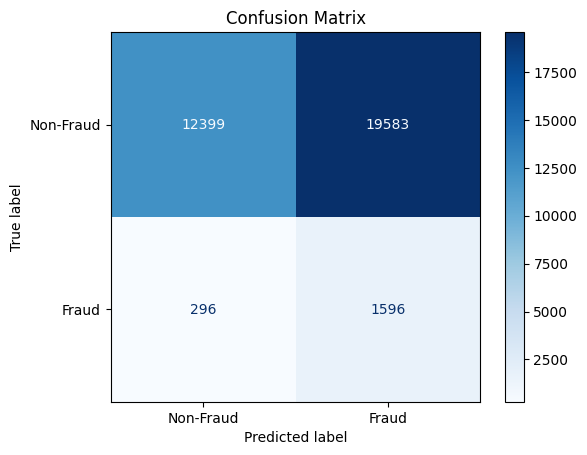

In [178]:
# confusion matrix heatmap
cm_heatmap(sm_pipeline, Xt=X_test_lrfe, yt=y_test)

In [179]:
# evaluation metric dataframe
df_smote = metrics('smote', sm_pipeline, Xt=X_test_lrfe, yt=y_test)
df_smote

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
smote,0.413149,0.075358,0.843552,0.615619,0.681195


## RandomUnderSampler

In [180]:
from imblearn.under_sampling import RandomUnderSampler

In [181]:
# reducing the negative class to sample size 500
rus = RandomUnderSampler(sampling_strategy={0: 500}, random_state=10) 

# pipeline
rus_pipeline = imb_pipe(rus, lr_pipeline)

In [182]:
# train model
rus_pipeline.fit(X_train_lrfe,y_train)

Pipeline(steps=[('randomundersampler',
                 RandomUnderSampler(random_state=10,
                                    sampling_strategy={0: 500})),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(max_iter=2000,
                                                     n_jobs=-1))]))])

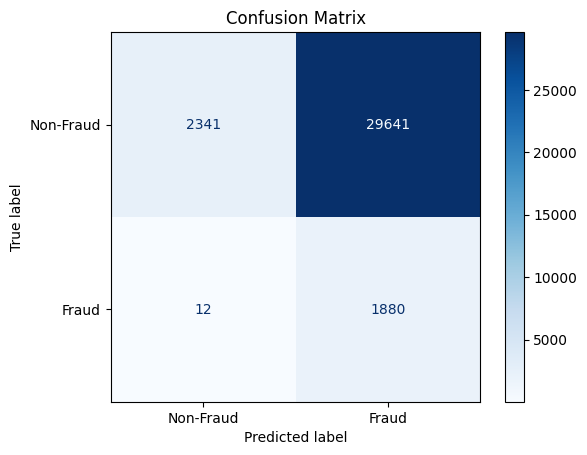

In [183]:
# confusion matrix heatmap
cm_heatmap(rus_pipeline, Xt=X_test_lrfe, yt=y_test)

In [184]:
# evaluation metric dataframe
df_random_undersampling = metrics('random_undersampling', rus_pipeline, Xt=X_test_lrfe, yt=y_test)
df_random_undersampling

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
random_undersampling,0.124609,0.059643,0.993658,0.533427,0.737364


## NearMiss

In [185]:
from imblearn.under_sampling import NearMiss

In [186]:
# undersample majority class by NearMiss version-3 algorithm
nm = NearMiss(version=3, n_jobs=-1)

# pipeline
nm_pipeline = imb_pipe(nm, lr_pipeline)

In [187]:
# train model
nm_pipeline.fit(X_train_lrfe,y_train)

Pipeline(steps=[('nearmiss', NearMiss(n_jobs=-1, version=3)),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(max_iter=2000,
                                                     n_jobs=-1))]))])

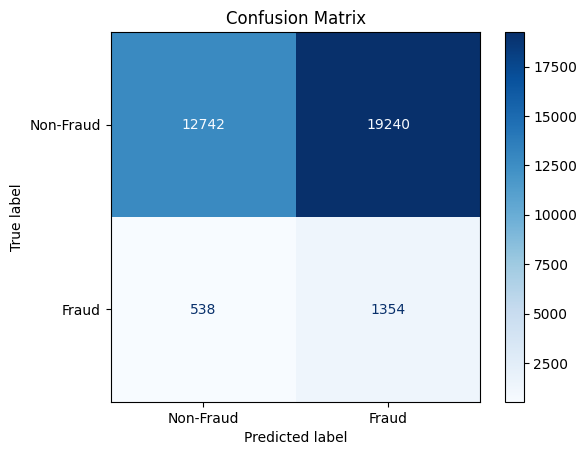

In [188]:
# confusion matrix heatmap
cm_heatmap(nm_pipeline, Xt=X_test_lrfe, yt=y_test)

In [189]:
# evaluation metric dataframe
df_nearmiss = metrics('nearmiss', nm_pipeline, Xt=X_test_lrfe, yt=y_test)
df_nearmiss

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
nearmiss,0.41613,0.065747,0.715645,0.557028,0.581331


3.3 Combination of over- and undersampling


In [190]:
# pipeline combining Smote followed by NearMiss
sm_nm_pipeline = imb_pipe(sm, nm, lr_pipeline)

In [192]:
# train model
sm_nm_pipeline.fit(X_train_lrfe,y_train)

Pipeline(steps=[('smote',
                 SMOTE(random_state=10, sampling_strategy={1: 200000})),
                ('nearmiss', NearMiss(n_jobs=-1, version=3)),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(max_iter=2000,
                                                     n_jobs=-1))]))])

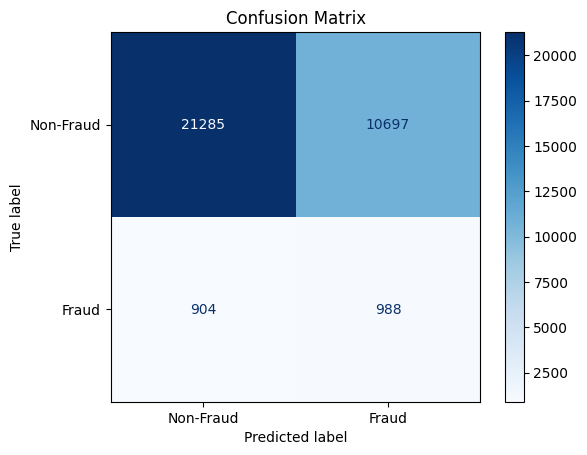

In [193]:
# confusion matrix heatmap
cm_heatmap(sm_nm_pipeline, Xt=X_test_lrfe, yt=y_test)

In [194]:
# evaluation metric dataframe
df_over_under_sampling = metrics('over_under_sampling', sm_nm_pipeline, Xt=X_test_lrfe, yt=y_test)
df_over_under_sampling

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
over_under_sampling,0.657525,0.084553,0.522199,0.593865,0.647837


In [195]:
summary_table=pd.concat([df_unbalanced_logistic,
           df_balanced_logistic,
           df_random_oversampling, 
           df_smote,
           df_random_undersampling,
           df_nearmiss,
           df_over_under_sampling]
         ).sort_values(['roc_auc_score'], ascending=False)
summary_table[
    ["roc_auc_score"] + [c for c in summary_table.columns if c != "roc_auc_score"]
]

,roc_auc_score,accuracy_score,precision_score,recall_score,balanced_accuracy_score
balanced_logistic,0.741780,0.626911,0.102000,0.727801,0.674372
random_oversampling,0.741639,0.404529,0.079735,0.916490,0.645366
unbalanced_logistic,0.741213,0.944028,0.409091,0.004757,0.502175
random_undersampling,0.737364,0.124609,0.059643,0.993658,0.533427
smote,0.681195,0.413149,0.075358,0.843552,0.615619
over_under_sampling,0.647837,0.657525,0.084553,0.522199,0.593865
nearmiss,0.581331,0.416130,0.065747,0.715645,0.557028


## Unbalanced Random Forest


In [234]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = make_pipeline(
    RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=20,
        random_state=42,
        n_jobs=-1
    )
)


In [235]:
#Features for random forest
X_train_rf=X_train_basefe[['log_total_consumption', 'no_consumption_flag', 'n_invoices', 'invoice_span_days',
                            'meter_delta_std', 'delta_per_month_std', 'coef_nunique', 'coef_changed', 'code_nunique',
                             'remark_nunique', 'counter_type2', 'region_ord', 'client_catg_ord', 'district_ord']]


In [236]:
X_test_rf=X_test_basefe[['log_total_consumption', 'no_consumption_flag', 'n_invoices', 'invoice_span_days',
                            'meter_delta_std', 'delta_per_month_std', 'coef_nunique', 'coef_changed', 'code_nunique',
                             'remark_nunique', 'counter_type2', 'region_ord', 'client_catg_ord', 'district_ord']]


In [237]:
X_test_rf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33874 entries, 55911 to 120685
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   log_total_consumption  33874 non-null  float64
 1   no_consumption_flag    33874 non-null  int64  
 2   n_invoices             33874 non-null  int64  
 3   invoice_span_days      33874 non-null  int64  
 4   meter_delta_std        33874 non-null  float64
 5   delta_per_month_std    33874 non-null  float64
 6   coef_nunique           33874 non-null  int64  
 7   coef_changed           33874 non-null  int64  
 8   code_nunique           33874 non-null  int64  
 9   remark_nunique         33874 non-null  int64  
 10  counter_type2          33874 non-null  int64  
 11  region_ord             33874 non-null  int64  
 12  client_catg_ord        33874 non-null  int64  
 13  district_ord           33874 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 3.9 MB


In [238]:
# train model
rf_pipeline.fit(X_train_rf,y_train)


Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=20, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

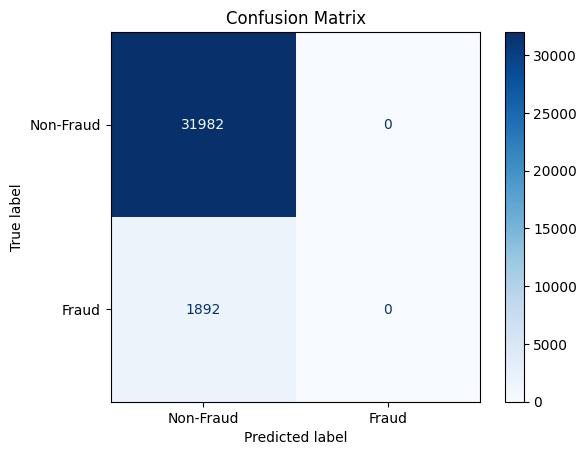

In [239]:
# confusion matrix heatmap
cm_heatmap(rf_pipeline, Xt=X_test_rf, yt=y_test)

In [240]:
df_random_forest = metrics("random_forest", rf_pipeline, Xt=X_test_rf, yt=y_test)
df_random_forest

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
random_forest,0.944146,0.0,0.0,0.5,0.774848


## Balanced Random Forest

In [241]:
from sklearn.ensemble import RandomForestClassifier

rfb_pipeline = make_pipeline(
    RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=20,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )
)


In [242]:
# train model
rfb_pipeline.fit(X_train_rf,y_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=20, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

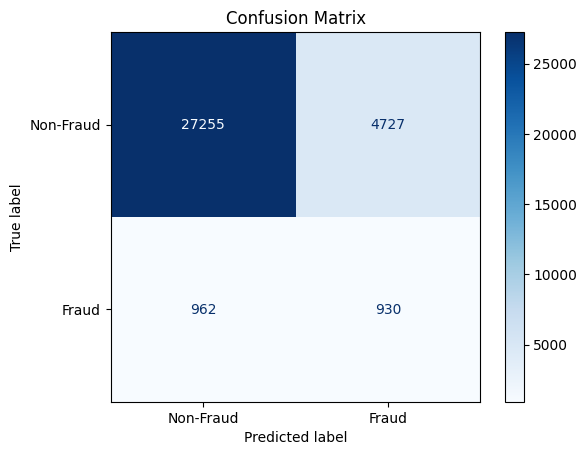

In [243]:
# confusion matrix heatmap
cm_heatmap(rfb_pipeline, Xt=X_test_rf, yt=y_test)

In [244]:
df_brandom_forest = metrics("balanced_random_forest", rfb_pipeline, Xt=X_test_rf, yt=y_test)
df_brandom_forest

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
balanced_random_forest,0.832054,0.164398,0.491543,0.671871,0.775106


## Balancing Target Column

# RandomOverSampler

In [264]:
# pipeline
ros_pipeline_rf = imb_pipe(ros, rf_pipeline)
# train model
ros_pipeline_rf.fit(X_train_rf,y_train)

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=10,
                                   sampling_strategy={1: 200000})),
                ('pipeline',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(min_samples_leaf=20,
                                                         n_estimators=300,
                                                         n_jobs=-1,
                                                         random_state=42))]))])

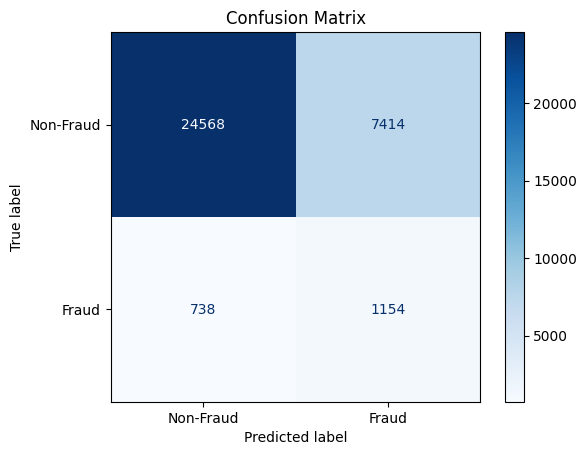

In [265]:
# confusion matrix heatmap
cm_heatmap(ros_pipeline_rf, Xt=X_test_rf, yt=y_test)


In [266]:
df_random_oversampling_rf = metrics("random_oversampling_rf", ros_pipeline_rf, Xt=X_test_rf, yt=y_test)
df_random_oversampling_rf 

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
random_oversampling_rf,0.759343,0.134687,0.609937,0.689059,0.772235


## Synthetic minority oversampling to sample size 200_000

In [248]:
# pipeline
sm_pipeline_rf = imb_pipe(sm, rf_pipeline)
# train model
sm_pipeline_rf.fit(X_train_rf,y_train)

Pipeline(steps=[('smote',
                 SMOTE(random_state=10, sampling_strategy={1: 200000})),
                ('pipeline',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(min_samples_leaf=20,
                                                         n_estimators=300,
                                                         n_jobs=-1,
                                                         random_state=42))]))])

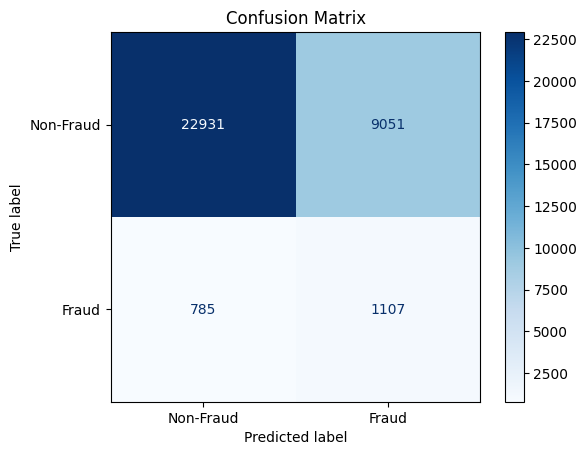

In [249]:
# confusion matrix heatmap
cm_heatmap(sm_pipeline_rf, Xt=X_test_rf, yt=y_test)

In [250]:
df_smote_rf = metrics("smote_rf", sm_pipeline_rf, Xt=X_test_rf, yt=y_test)
df_smote_rf 

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
smote_rf,0.70963,0.108978,0.585095,0.651046,0.718011


## Random Under Sampler

In [251]:
# pipeline
rus_pipeline_rf = imb_pipe(rus, rf_pipeline)
# train model
rus_pipeline_rf.fit(X_train_rf,y_train)


Pipeline(steps=[('randomundersampler',
                 RandomUnderSampler(random_state=10,
                                    sampling_strategy={0: 500})),
                ('pipeline',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(min_samples_leaf=20,
                                                         n_estimators=300,
                                                         n_jobs=-1,
                                                         random_state=42))]))])

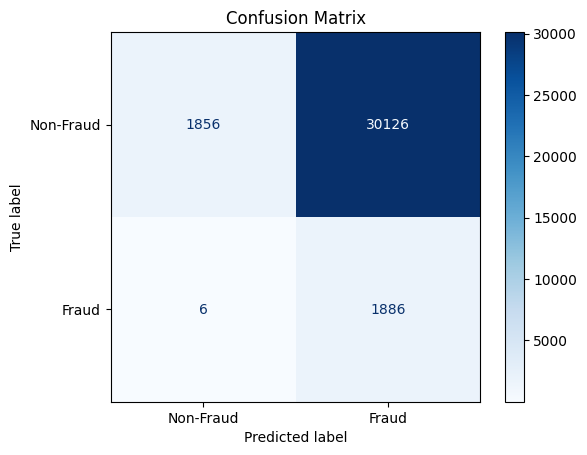

In [252]:
# confusion matrix heatmap
cm_heatmap(rus_pipeline_rf, Xt=X_test_rf, yt=y_test)

In [253]:
df_rundersampling_rf = metrics("random_undersampling_rf", rus_pipeline_rf, Xt=X_test_rf, yt=y_test)
df_rundersampling_rf 

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
random_undersampling_rf,0.110468,0.058915,0.996829,0.527431,0.75374


## Near Miss

In [254]:
# pipeline
nm_pipeline_rf = imb_pipe(nm, rf_pipeline)
# train model
nm_pipeline_rf.fit(X_train_rf,y_train)

Pipeline(steps=[('nearmiss', NearMiss(n_jobs=-1, version=3)),
                ('pipeline',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(min_samples_leaf=20,
                                                         n_estimators=300,
                                                         n_jobs=-1,
                                                         random_state=42))]))])

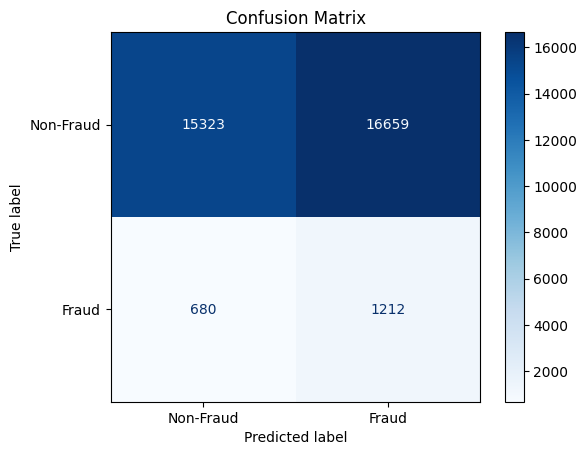

In [255]:
# confusion matrix heatmap
cm_heatmap(nm_pipeline_rf, Xt=X_test_rf, yt=y_test)

In [256]:
df_nearmiss_rf = metrics("near_miss_rf", nm_pipeline_rf, Xt=X_test_rf, yt=y_test)
df_nearmiss_rf 

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
near_miss_rf,0.488132,0.067819,0.640592,0.559853,0.592184


## Combining smote followed by NearMiss

In [257]:
# pipeline combining Smote followed by NearMiss
sm_nm_pipeline_rf = imb_pipe(sm, nm, rf_pipeline)

# train model
sm_nm_pipeline_rf.fit(X_train_rf,y_train)

Pipeline(steps=[('smote',
                 SMOTE(random_state=10, sampling_strategy={1: 200000})),
                ('nearmiss', NearMiss(n_jobs=-1, version=3)),
                ('pipeline',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(min_samples_leaf=20,
                                                         n_estimators=300,
                                                         n_jobs=-1,
                                                         random_state=42))]))])

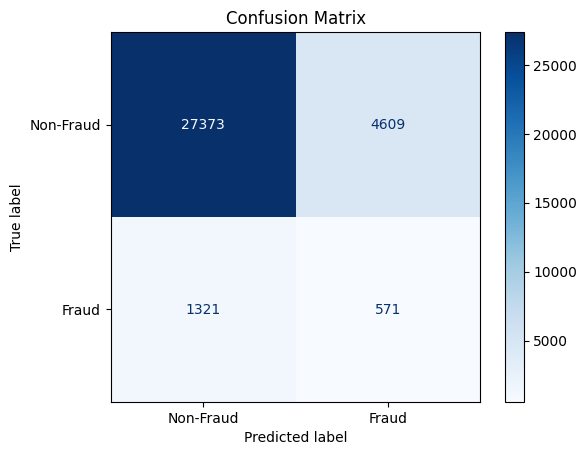

In [258]:
# confusion matrix heatmap
cm_heatmap(sm_nm_pipeline_rf, Xt=X_test_rf, yt=y_test)

In [259]:
df_sm_nm_rf = metrics("smote_nm_rf", sm_nm_pipeline_rf, Xt=X_test_rf, yt=y_test)
df_sm_nm_rf 

,accuracy_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score
smote_nm_rf,0.824939,0.110232,0.301797,0.578842,0.693189


In [267]:
summary_table_rf=pd.concat([df_random_forest,
           df_brandom_forest,
           df_random_oversampling_rf, 
           df_smote_rf,
           df_rundersampling_rf,
           df_nearmiss_rf,
           df_sm_nm_rf]
         ).sort_values(['roc_auc_score'], ascending=False)
summary_table_rf[
    ["roc_auc_score"] + [c for c in summary_table.columns if c != "roc_auc_score"]
]

,roc_auc_score,accuracy_score,precision_score,recall_score,balanced_accuracy_score
balanced_random_forest,0.775106,0.832054,0.164398,0.491543,0.671871
random_forest,0.774848,0.944146,0.000000,0.000000,0.500000
random_oversampling_rf,0.772235,0.759343,0.134687,0.609937,0.689059
random_undersampling_rf,0.753740,0.110468,0.058915,0.996829,0.527431
smote_rf,0.718011,0.709630,0.108978,0.585095,0.651046
smote_nm_rf,0.693189,0.824939,0.110232,0.301797,0.578842
near_miss_rf,0.592184,0.488132,0.067819,0.640592,0.559853


In [270]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(model, Xt, yt, label=None):
    y_proba = model.predict_proba(Xt)[:, 1]
    fpr, tpr, _ = roc_curve(yt, y_proba)
    auc = roc_auc_score(yt, y_proba)

    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")


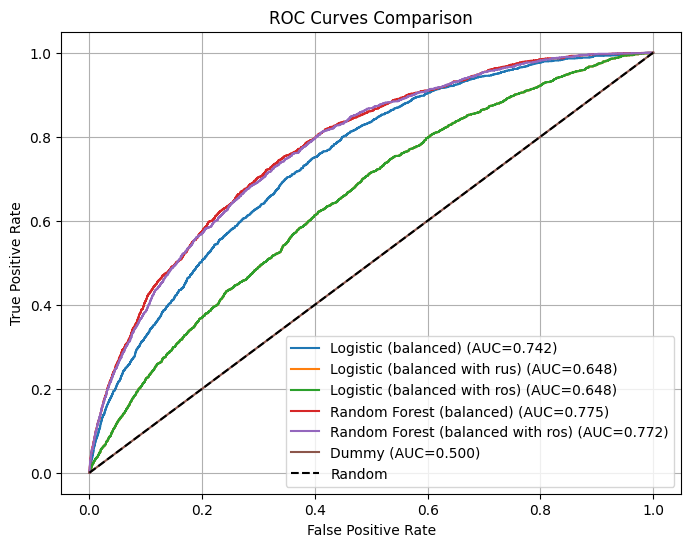

In [269]:
plt.figure(figsize=(8, 6))

# Logistic
plot_roc(lrb_pipeline, X_test_lrfe, y_test, label="Logistic (balanced)")

# Logistic with rus
plot_roc(rus_pipeline, X_test_lrfe, y_test, label="Logistic (balanced with rus)")

# Logistic with ros
plot_roc(ros_pipeline, X_test_lrfe, y_test, label="Logistic (balanced with ros)")

# Random Forest
plot_roc(rfb_pipeline, X_test_rf, y_test, label="Random Forest (balanced)")

# Random Forest ros
plot_roc(ros_pipeline_rf, X_test_rf, y_test, label="Random Forest (balanced with ros)")

# Optional: Dummy
plot_roc(dummy, X_test_basefe, y_test, label="Dummy")

# diagonal reference line
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.grid(True)
plt.savefig("ROC_curves")
plt.show()


Balancing methods change recall/precision trade-offs,
but only marginally affect ROC.

That means:

Logistic regression’s ranking ceiling with your current features is ~0.73

Random Forest pushed that ceiling to ~0.78

That’s a real, meaningful improvement.

Why ROC is important for business (and what it does not do)
🔑 Why ROC matters to the business

Businesses don’t ask:

“Is this fraud above 0.5?”

They ask:

“Which clients should we investigate first?”

ROC measures:

ranking quality

ability to prioritize cases

performance independent of threshold or capacity

That’s why:

ROC is stable across balancing

ROC lets you choose thresholds later

Balancing changes how many frauds you flag, not how well you rank them — ROC tells you how good your ranking truly is.

In [271]:
#Feature Importance Random Forest
from sklearn.inspection import permutation_importance

r = permutation_importance(
    rfb_pipeline,
    X_test_rf,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

perm_df = (
    pd.DataFrame({
        "feature": X_test_rf.columns,
        "importance": r.importances_mean
    })
    .sort_values("importance", ascending=False)
)

perm_df.head(10)


,feature,importance
3,invoice_span_days,0.061451
5,delta_per_month_std,0.038096
8,code_nunique,0.031311
11,region_ord,0.024241
0,log_total_consumption,0.019951
2,n_invoices,0.013884
9,remark_nunique,0.012559
4,meter_delta_std,0.007358
13,district_ord,0.006395
12,client_catg_ord,0.001611


Summary: what to KEEP vs DROP (clear answer)
✅ Strong core features (DO NOT DROP)
invoice_span_days
delta_per_month_std
code_nunique
region_ord
log_total_consumption
n_invoices
remark_nunique

⚠️ Optional / redundant (can drop if simplifying)
meter_delta_std
district_ord

❌ Weak — safe to drop
client_catg_ord


In [157]:
#Feature Importance
from sklearn.inspection import permutation_importance

r = permutation_importance(
    lrb_pipeline,
    X_test_lrfe,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

perm_df = (
    pd.DataFrame({
        "feature": X_test_lrfe.columns,
        "importance": r.importances_mean
    })
    .sort_values("importance", ascending=False)
)

perm_df.head(10)

,feature,importance
3,invoice_span_days,0.145204
10,code_nunique,0.079816
13,region_ord,0.018490
6,delta_per_month_mean,0.014576
5,meter_delta_std,0.013785
15,district_ord,0.002515
2,n_invoices,0.002225
4,meter_delta_median,0.000789
1,no_consumption_flag,0.000631
8,coef_nunique,0.000076


In [272]:
#Grid Search-Logistic Regression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000))
])

param_grid_log = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "liblinear"],
    "clf__class_weight": [None, "balanced"]
}

gs_log = GridSearchCV(
    estimator=log_pipe,
    param_grid=param_grid_log,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs_log.fit(X_train_lrfe, y_train.squeeze())

print("Best ROC (CV):", gs_log.best_score_)
print("Best params:", gs_log.best_params_)

best_log_model = gs_log.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/ozlem/SPICED_2/fraud_detection_gas_electricity/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ozlem/SPICED_2/fraud_detection_gas_electricity/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ozlem/SPICED_2/fraud_detection_gas_electricity/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ozlem/SPICED_2/fraud_detection_gas_electricity/.venv/lib/pyth

Best ROC (CV): 0.7398977044429571
Best params: {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


In [273]:
#on Test test
best_log_model = gs_log.best_estimator_

y_proba_log = best_log_model.predict_proba(X_test_lrfe)[:, 1]

print("Test ROC:", roc_auc_score(y_test, y_proba_log))
print("Test PR-AUC:", average_precision_score(y_test, y_proba_log))


Test ROC: 0.7417778803431053
Test PR-AUC: 0.15153035352262895


Almost identical to CV ROC ≈ 0.740. Sign of excellent generalization, Strong evidence there is no overfitting
Logistic regression has reached its true linear ceiling on this dataset.

Baseline Random PR-AUC ≈ fraud rate ≈ 5–6%==>LR model achieves ~15%

In [282]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import pandas as pd
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": randint(200, 700),
    "max_depth": [None, 8, 12, 20],
    "min_samples_leaf": randint(1, 21),
    "min_samples_split": randint(2, 21),
    "max_features": ["sqrt", "log2"],
    "class_weight": [None, "balanced"],
}

rs_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=60,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
y_train_r1=y_train.squeeze()
rs_rf.fit(X_train_rf, y_train_r1)
print(rs_rf.best_score_, rs_rf.best_params_)
best_rf_model = rs_rf.best_estimator_



Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 